In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 
using Statistics 

  Activating environment at `C:\Users\sriku\Downloads\OCRL Project\OCRL Project\Project.toml`


In [2]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","planar_vehicle.jl")) 

check_dynamic_feasibility (generic function with 1 method)

In [3]:
function double_integrator_AB(dt)::Tuple{Matrix,Matrix}
    Ac = [0 0 1 0;
          0 0 0 1;
          0 0 0 0;
          0 0 0 0.]
    Bc = [0 0;
          0 0;
          1 0;
          0 1]
    nx, nu = size(Bc)
        
    # TODO: discretize this linear system using the Matrix Exponential
    
    M = [Ac Bc ; zeros(2,6)]*dt
    M = exp(M)
   
    A = M[1:4,1:4] # TODO 
    B = M[1:4,5:6] # TODO 
    
    @assert size(A) == (nx,nx)
    @assert size(B) == (nx,nu)
    
    return A, B 
end 

double_integrator_AB (generic function with 1 method)

In [4]:
A,B = double_integrator_AB(0.5)

([1.0 0.0 0.5 0.0; 0.0 1.0 0.0 0.5; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.125 0.0; 0.0 0.125; 0.5 0.0; 0.0 0.5])

In [51]:
nx = 4
nu = 2
dt = 0.0009
tf = 12
t_vec = 0:dt:tf 
N = length(t_vec)

    
### Reference Trajectories
x1 = range(1, stop=150, length=N);
y1 = 1.5*ones(N); 

xdot = 3*ones(N);
ydot = 0*ones(N);

x2 = 50;
y2 = 1.5;


#
Kp = 10
Kd = 6
K1 = 15

x0 = [0;1.5;0.5;0]

A1 = hcat(x1,y1,xdot,ydot);
xref = [A1[i,:] for i in 1:size(A1,1)] ;

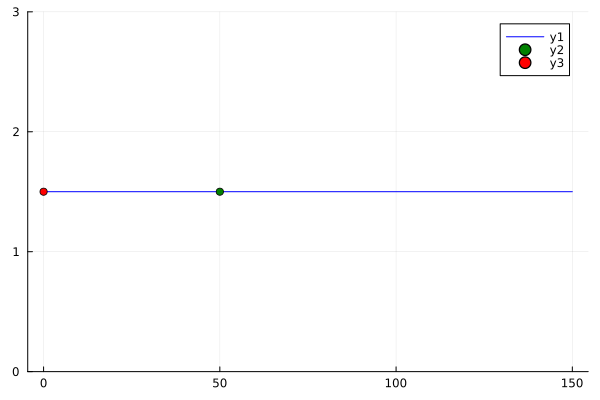

In [52]:
plot(x1,y1,ylims = [0,3],color= "blue")
scatter!([x2],[y2],color = "green")
scatter!([x0[1]],[x0[2]],color = "red")

In [53]:
print(xref)

[[1.0, 1.5, 3.0, 0.0], [1.0111752793819846, 1.5, 3.0, 0.0], [1.0223505587639692, 1.5, 3.0, 0.0], [1.0335258381459536, 1.5, 3.0, 0.0], [1.0447011175279382, 1.5, 3.0, 0.0], [1.0558763969099227, 1.5, 3.0, 0.0], [1.0670516762919073, 1.5, 3.0, 0.0], [1.078226955673892, 1.5, 3.0, 0.0], [1.0894022350558763, 1.5, 3.0, 0.0], [1.100577514437861, 1.5, 3.0, 0.0], [1.1117527938198455, 1.5, 3.0, 0.0], [1.12292807320183, 1.5, 3.0, 0.0], [1.1341033525838147, 1.5, 3.0, 0.0], [1.145278631965799, 1.5, 3.0, 0.0], [1.1564539113477836, 1.5, 3.0, 0.0], [1.1676291907297682, 1.5, 3.0, 0.0], [1.1788044701117528, 1.5, 3.0, 0.0], [1.1899797494937374, 1.5, 3.0, 0.0], [1.2011550288757218, 1.5, 3.0, 0.0], [1.2123303082577064, 1.5, 3.0, 0.0], [1.223505587639691, 1.5, 3.0, 0.0], [1.2346808670216756, 1.5, 3.0, 0.0], [1.2458561464036602, 1.5, 3.0, 0.0], [1.2570314257856448, 1.5, 3.0, 0.0], [1.2682067051676291, 1.5, 3.0, 0.0], [1.2793819845496137, 1.5, 3.0, 0.0], [1.2905572639315983, 1.5, 3.0, 0.0], [1.301732543313583, 1

, 3.0, 0.0], [4.151428785719643, 1.5, 3.0, 0.0], [4.162604065101627, 1.5, 3.0, 0.0], [4.173779344483612, 1.5, 3.0, 0.0], [4.184954623865597, 1.5, 3.0, 0.0], [4.196129903247582, 1.5, 3.0, 0.0], [4.2073051826295655, 1.5, 3.0, 0.0], [4.21848046201155, 1.5, 3.0, 0.0], [4.229655741393535, 1.5, 3.0, 0.0], [4.240831020775519, 1.5, 3.0, 0.0], [4.252006300157504, 1.5, 3.0, 0.0], [4.263181579539489, 1.5, 3.0, 0.0], [4.274356858921473, 1.5, 3.0, 0.0], [4.2855321383034575, 1.5, 3.0, 0.0], [4.296707417685442, 1.5, 3.0, 0.0], [4.307882697067427, 1.5, 3.0, 0.0], [4.319057976449411, 1.5, 3.0, 0.0], [4.330233255831396, 1.5, 3.0, 0.0], [4.341408535213381, 1.5, 3.0, 0.0], [4.352583814595365, 1.5, 3.0, 0.0], [4.363759093977349, 1.5, 3.0, 0.0], [4.374934373359334, 1.5, 3.0, 0.0], [4.386109652741318, 1.5, 3.0, 0.0], [4.397284932123303, 1.5, 3.0, 0.0], [4.408460211505288, 1.5, 3.0, 0.0], [4.419635490887273, 1.5, 3.0, 0.0], [4.4308107702692565, 1.5, 3.0, 0.0], [4.441986049651241, 1.5, 3.0, 0.0], [4.4531613290

[6.94524863121578, 1.5, 3.0, 0.0], [6.956423910597765, 1.5, 3.0, 0.0], [6.967599189979749, 1.5, 3.0, 0.0], [6.978774469361734, 1.5, 3.0, 0.0], [6.989949748743719, 1.5, 3.0, 0.0], [7.001125028125704, 1.5, 3.0, 0.0], [7.0123003075076875, 1.5, 3.0, 0.0], [7.023475586889672, 1.5, 3.0, 0.0], [7.034650866271657, 1.5, 3.0, 0.0], [7.045826145653641, 1.5, 3.0, 0.0], [7.057001425035626, 1.5, 3.0, 0.0], [7.068176704417611, 1.5, 3.0, 0.0], [7.079351983799595, 1.5, 3.0, 0.0], [7.090527263181579, 1.5, 3.0, 0.0], [7.101702542563564, 1.5, 3.0, 0.0], [7.112877821945549, 1.5, 3.0, 0.0], [7.124053101327533, 1.5, 3.0, 0.0], [7.135228380709518, 1.5, 3.0, 0.0], [7.146403660091503, 1.5, 3.0, 0.0], [7.157578939473487, 1.5, 3.0, 0.0], [7.168754218855471, 1.5, 3.0, 0.0], [7.179929498237456, 1.5, 3.0, 0.0], [7.19110477761944, 1.5, 3.0, 0.0], [7.202280057001425, 1.5, 3.0, 0.0], [7.21345533638341, 1.5, 3.0, 0.0], [7.224630615765395, 1.5, 3.0, 0.0], [7.2358058951473785, 1.5, 3.0, 0.0], [7.246981174529363, 1.5, 3.0,

 0.0], [9.604965124128103, 1.5, 3.0, 0.0], [9.616140403510087, 1.5, 3.0, 0.0], [9.627315682892073, 1.5, 3.0, 0.0], [9.638490962274057, 1.5, 3.0, 0.0], [9.64966624165604, 1.5, 3.0, 0.0], [9.660841521038027, 1.5, 3.0, 0.0], [9.67201680042001, 1.5, 3.0, 0.0], [9.683192079801994, 1.5, 3.0, 0.0], [9.69436735918398, 1.5, 3.0, 0.0], [9.705542638565964, 1.5, 3.0, 0.0], [9.716717917947948, 1.5, 3.0, 0.0], [9.727893197329934, 1.5, 3.0, 0.0], [9.739068476711918, 1.5, 3.0, 0.0], [9.750243756093901, 1.5, 3.0, 0.0], [9.761419035475887, 1.5, 3.0, 0.0], [9.772594314857871, 1.5, 3.0, 0.0], [9.783769594239857, 1.5, 3.0, 0.0], [9.79494487362184, 1.5, 3.0, 0.0], [9.806120153003825, 1.5, 3.0, 0.0], [9.81729543238581, 1.5, 3.0, 0.0], [9.828470711767794, 1.5, 3.0, 0.0], [9.839645991149778, 1.5, 3.0, 0.0], [9.850821270531764, 1.5, 3.0, 0.0], [9.861996549913748, 1.5, 3.0, 0.0], [9.873171829295732, 1.5, 3.0, 0.0], [9.884347108677717, 1.5, 3.0, 0.0], [9.895522388059701, 1.5, 3.0, 0.0], [9.906697667441685, 1.5, 3

, 1.5, 3.0, 0.0], [12.979899497487438, 1.5, 3.0, 0.0], [12.991074776869421, 1.5, 3.0, 0.0], [13.002250056251407, 1.5, 3.0, 0.0], [13.013425335633391, 1.5, 3.0, 0.0], [13.024600615015375, 1.5, 3.0, 0.0], [13.03577589439736, 1.5, 3.0, 0.0], [13.046951173779345, 1.5, 3.0, 0.0], [13.058126453161329, 1.5, 3.0, 0.0], [13.069301732543314, 1.5, 3.0, 0.0], [13.080477011925298, 1.5, 3.0, 0.0], [13.091652291307282, 1.5, 3.0, 0.0], [13.102827570689268, 1.5, 3.0, 0.0], [13.114002850071252, 1.5, 3.0, 0.0], [13.125178129453236, 1.5, 3.0, 0.0], [13.136353408835221, 1.5, 3.0, 0.0], [13.147528688217205, 1.5, 3.0, 0.0], [13.15870396759919, 1.5, 3.0, 0.0], [13.169879246981175, 1.5, 3.0, 0.0], [13.181054526363159, 1.5, 3.0, 0.0], [13.192229805745143, 1.5, 3.0, 0.0], [13.203405085127129, 1.5, 3.0, 0.0], [13.214580364509112, 1.5, 3.0, 0.0], [13.225755643891098, 1.5, 3.0, 0.0], [13.236930923273082, 1.5, 3.0, 0.0], [13.248106202655066, 1.5, 3.0, 0.0], [13.259281482037052, 1.5, 3.0, 0.0], [13.270456761419036, 1

 0.0], [15.494337358433961, 1.5, 3.0, 0.0], [15.505512637815945, 1.5, 3.0, 0.0], [15.51668791719793, 1.5, 3.0, 0.0], [15.527863196579915, 1.5, 3.0, 0.0], [15.539038475961899, 1.5, 3.0, 0.0], [15.550213755343883, 1.5, 3.0, 0.0], [15.561389034725869, 1.5, 3.0, 0.0], [15.572564314107852, 1.5, 3.0, 0.0], [15.583739593489836, 1.5, 3.0, 0.0], [15.594914872871822, 1.5, 3.0, 0.0], [15.606090152253806, 1.5, 3.0, 0.0], [15.617265431635792, 1.5, 3.0, 0.0], [15.628440711017776, 1.5, 3.0, 0.0], [15.63961599039976, 1.5, 3.0, 0.0], [15.650791269781745, 1.5, 3.0, 0.0], [15.66196654916373, 1.5, 3.0, 0.0], [15.673141828545713, 1.5, 3.0, 0.0], [15.684317107927699, 1.5, 3.0, 0.0], [15.695492387309683, 1.5, 3.0, 0.0], [15.706667666691667, 1.5, 3.0, 0.0], [15.717842946073652, 1.5, 3.0, 0.0], [15.729018225455636, 1.5, 3.0, 0.0], [15.74019350483762, 1.5, 3.0, 0.0], [15.751368784219606, 1.5, 3.0, 0.0], [15.76254406360159, 1.5, 3.0, 0.0], [15.773719342983574, 1.5, 3.0, 0.0], [15.78489462236556, 1.5, 3.0, 0.0], 

, 3.0, 0.0], [18.26580664516613, 1.5, 3.0, 0.0], [18.276981924548114, 1.5, 3.0, 0.0], [18.288157203930098, 1.5, 3.0, 0.0], [18.29933248331208, 1.5, 3.0, 0.0], [18.31050776269407, 1.5, 3.0, 0.0], [18.321683042076053, 1.5, 3.0, 0.0], [18.332858321458037, 1.5, 3.0, 0.0], [18.34403360084002, 1.5, 3.0, 0.0], [18.355208880222005, 1.5, 3.0, 0.0], [18.36638415960399, 1.5, 3.0, 0.0], [18.377559438985976, 1.5, 3.0, 0.0], [18.38873471836796, 1.5, 3.0, 0.0], [18.399909997749944, 1.5, 3.0, 0.0], [18.411085277131928, 1.5, 3.0, 0.0], [18.422260556513912, 1.5, 3.0, 0.0], [18.433435835895896, 1.5, 3.0, 0.0], [18.444611115277883, 1.5, 3.0, 0.0], [18.455786394659867, 1.5, 3.0, 0.0], [18.46696167404185, 1.5, 3.0, 0.0], [18.478136953423835, 1.5, 3.0, 0.0], [18.48931223280582, 1.5, 3.0, 0.0], [18.500487512187803, 1.5, 3.0, 0.0], [18.51166279156979, 1.5, 3.0, 0.0], [18.522838070951774, 1.5, 3.0, 0.0], [18.53401335033376, 1.5, 3.0, 0.0], [18.545188629715742, 1.5, 3.0, 0.0], [18.556363909097726, 1.5, 3.0, 0.0]

[21.13785344633616, 1.5, 3.0, 0.0], [21.149028725718143, 1.5, 3.0, 0.0], [21.160204005100127, 1.5, 3.0, 0.0], [21.17137928448211, 1.5, 3.0, 0.0], [21.182554563864098, 1.5, 3.0, 0.0], [21.193729843246082, 1.5, 3.0, 0.0], [21.204905122628066, 1.5, 3.0, 0.0], [21.21608040201005, 1.5, 3.0, 0.0], [21.227255681392034, 1.5, 3.0, 0.0], [21.238430960774018, 1.5, 3.0, 0.0], [21.249606240156005, 1.5, 3.0, 0.0], [21.26078151953799, 1.5, 3.0, 0.0], [21.271956798919973, 1.5, 3.0, 0.0], [21.283132078301957, 1.5, 3.0, 0.0], [21.29430735768394, 1.5, 3.0, 0.0], [21.305482637065925, 1.5, 3.0, 0.0], [21.316657916447912, 1.5, 3.0, 0.0], [21.327833195829896, 1.5, 3.0, 0.0], [21.33900847521188, 1.5, 3.0, 0.0], [21.350183754593864, 1.5, 3.0, 0.0], [21.361359033975848, 1.5, 3.0, 0.0], [21.372534313357836, 1.5, 3.0, 0.0], [21.38370959273982, 1.5, 3.0, 0.0], [21.394884872121803, 1.5, 3.0, 0.0], [21.406060151503787, 1.5, 3.0, 0.0], [21.41723543088577, 1.5, 3.0, 0.0], [21.428410710267755, 1.5, 3.0, 0.0], [21.43958

 1.5, 3.0, 0.0], [23.831095777394435, 1.5, 3.0, 0.0], [23.84227105677642, 1.5, 3.0, 0.0], [23.853446336158402, 1.5, 3.0, 0.0], [23.86462161554039, 1.5, 3.0, 0.0], [23.875796894922374, 1.5, 3.0, 0.0], [23.886972174304358, 1.5, 3.0, 0.0], [23.89814745368634, 1.5, 3.0, 0.0], [23.909322733068326, 1.5, 3.0, 0.0], [23.92049801245031, 1.5, 3.0, 0.0], [23.931673291832297, 1.5, 3.0, 0.0], [23.94284857121428, 1.5, 3.0, 0.0], [23.954023850596265, 1.5, 3.0, 0.0], [23.96519912997825, 1.5, 3.0, 0.0], [23.976374409360233, 1.5, 3.0, 0.0], [23.98754968874222, 1.5, 3.0, 0.0], [23.998724968124204, 1.5, 3.0, 0.0], [24.009900247506188, 1.5, 3.0, 0.0], [24.021075526888172, 1.5, 3.0, 0.0], [24.032250806270156, 1.5, 3.0, 0.0], [24.04342608565214, 1.5, 3.0, 0.0], [24.054601365034127, 1.5, 3.0, 0.0], [24.06577664441611, 1.5, 3.0, 0.0], [24.076951923798095, 1.5, 3.0, 0.0], [24.08812720318008, 1.5, 3.0, 0.0], [24.099302482562063, 1.5, 3.0, 0.0], [24.110477761944047, 1.5, 3.0, 0.0], [24.121653041326034, 1.5, 3.0, 

0.0], [26.61374034350859, 1.5, 3.0, 0.0], [26.624915622890573, 1.5, 3.0, 0.0], [26.636090902272556, 1.5, 3.0, 0.0], [26.64726618165454, 1.5, 3.0, 0.0], [26.658441461036524, 1.5, 3.0, 0.0], [26.669616740418512, 1.5, 3.0, 0.0], [26.680792019800496, 1.5, 3.0, 0.0], [26.69196729918248, 1.5, 3.0, 0.0], [26.703142578564464, 1.5, 3.0, 0.0], [26.714317857946448, 1.5, 3.0, 0.0], [26.72549313732843, 1.5, 3.0, 0.0], [26.73666841671042, 1.5, 3.0, 0.0], [26.747843696092403, 1.5, 3.0, 0.0], [26.759018975474387, 1.5, 3.0, 0.0], [26.77019425485637, 1.5, 3.0, 0.0], [26.781369534238355, 1.5, 3.0, 0.0], [26.792544813620342, 1.5, 3.0, 0.0], [26.803720093002326, 1.5, 3.0, 0.0], [26.81489537238431, 1.5, 3.0, 0.0], [26.826070651766294, 1.5, 3.0, 0.0], [26.837245931148278, 1.5, 3.0, 0.0], [26.84842121053026, 1.5, 3.0, 0.0], [26.85959648991225, 1.5, 3.0, 0.0], [26.870771769294233, 1.5, 3.0, 0.0], [26.881947048676217, 1.5, 3.0, 0.0], [26.8931223280582, 1.5, 3.0, 0.0], [26.904297607440185, 1.5, 3.0, 0.0], [26.91

 1.5, 3.0, 0.0], [29.306982674566864, 1.5, 3.0, 0.0], [29.318157953948848, 1.5, 3.0, 0.0], [29.329333233330832, 1.5, 3.0, 0.0], [29.34050851271282, 1.5, 3.0, 0.0], [29.351683792094803, 1.5, 3.0, 0.0], [29.362859071476787, 1.5, 3.0, 0.0], [29.37403435085877, 1.5, 3.0, 0.0], [29.385209630240755, 1.5, 3.0, 0.0], [29.39638490962274, 1.5, 3.0, 0.0], [29.407560189004727, 1.5, 3.0, 0.0], [29.41873546838671, 1.5, 3.0, 0.0], [29.429910747768695, 1.5, 3.0, 0.0], [29.44108602715068, 1.5, 3.0, 0.0], [29.452261306532662, 1.5, 3.0, 0.0], [29.463436585914646, 1.5, 3.0, 0.0], [29.474611865296634, 1.5, 3.0, 0.0], [29.485787144678618, 1.5, 3.0, 0.0], [29.4969624240606, 1.5, 3.0, 0.0], [29.508137703442586, 1.5, 3.0, 0.0], [29.51931298282457, 1.5, 3.0, 0.0], [29.530488262206553, 1.5, 3.0, 0.0], [29.54166354158854, 1.5, 3.0, 0.0], [29.552838820970525, 1.5, 3.0, 0.0], [29.56401410035251, 1.5, 3.0, 0.0], [29.575189379734493, 1.5, 3.0, 0.0], [29.586364659116477, 1.5, 3.0, 0.0], [29.597539938498464, 1.5, 3.0, 

, 3.0, 0.0], [32.100802520063, 1.5, 3.0, 0.0], [32.111977799444986, 1.5, 3.0, 0.0], [32.123153078826974, 1.5, 3.0, 0.0], [32.134328358208954, 1.5, 3.0, 0.0], [32.14550363759094, 1.5, 3.0, 0.0], [32.15667891697292, 1.5, 3.0, 0.0], [32.16785419635491, 1.5, 3.0, 0.0], [32.1790294757369, 1.5, 3.0, 0.0], [32.19020475511888, 1.5, 3.0, 0.0], [32.201380034500865, 1.5, 3.0, 0.0], [32.212555313882845, 1.5, 3.0, 0.0], [32.22373059326483, 1.5, 3.0, 0.0], [32.23490587264681, 1.5, 3.0, 0.0], [32.2460811520288, 1.5, 3.0, 0.0], [32.25725643141079, 1.5, 3.0, 0.0], [32.26843171079277, 1.5, 3.0, 0.0], [32.279606990174756, 1.5, 3.0, 0.0], [32.290782269556736, 1.5, 3.0, 0.0], [32.301957548938724, 1.5, 3.0, 0.0], [32.31313282832071, 1.5, 3.0, 0.0], [32.32430810770269, 1.5, 3.0, 0.0], [32.33548338708468, 1.5, 3.0, 0.0], [32.34665866646666, 1.5, 3.0, 0.0], [32.35783394584865, 1.5, 3.0, 0.0], [32.369009225230634, 1.5, 3.0, 0.0], [32.380184504612615, 1.5, 3.0, 0.0], [32.3913597839946, 1.5, 3.0, 0.0], [32.402535

, 1.5, 3.0, 0.0], [35.20753018825471, 1.5, 3.0, 0.0], [35.21870546763669, 1.5, 3.0, 0.0], [35.229880747018676, 1.5, 3.0, 0.0], [35.24105602640066, 1.5, 3.0, 0.0], [35.252231305782644, 1.5, 3.0, 0.0], [35.26340658516463, 1.5, 3.0, 0.0], [35.27458186454661, 1.5, 3.0, 0.0], [35.2857571439286, 1.5, 3.0, 0.0], [35.29693242331058, 1.5, 3.0, 0.0], [35.30810770269257, 1.5, 3.0, 0.0], [35.319282982074554, 1.5, 3.0, 0.0], [35.330458261456535, 1.5, 3.0, 0.0], [35.34163354083852, 1.5, 3.0, 0.0], [35.3528088202205, 1.5, 3.0, 0.0], [35.36398409960249, 1.5, 3.0, 0.0], [35.37515937898448, 1.5, 3.0, 0.0], [35.38633465836646, 1.5, 3.0, 0.0], [35.397509937748445, 1.5, 3.0, 0.0], [35.408685217130426, 1.5, 3.0, 0.0], [35.41986049651241, 1.5, 3.0, 0.0], [35.4310357758944, 1.5, 3.0, 0.0], [35.44221105527638, 1.5, 3.0, 0.0], [35.45338633465837, 1.5, 3.0, 0.0], [35.46456161404035, 1.5, 3.0, 0.0], [35.47573689342234, 1.5, 3.0, 0.0], [35.48691217280432, 1.5, 3.0, 0.0], [35.498087452186304, 1.5, 3.0, 0.0], [35.50

[37.96782419560489, 1.5, 3.0, 0.0], [37.97899947498687, 1.5, 3.0, 0.0], [37.99017475436886, 1.5, 3.0, 0.0], [38.001350033750846, 1.5, 3.0, 0.0], [38.01252531313283, 1.5, 3.0, 0.0], [38.023700592514814, 1.5, 3.0, 0.0], [38.034875871896794, 1.5, 3.0, 0.0], [38.04605115127878, 1.5, 3.0, 0.0], [38.05722643066077, 1.5, 3.0, 0.0], [38.06840171004275, 1.5, 3.0, 0.0], [38.07957698942474, 1.5, 3.0, 0.0], [38.09075226880672, 1.5, 3.0, 0.0], [38.101927548188705, 1.5, 3.0, 0.0], [38.11310282757069, 1.5, 3.0, 0.0], [38.12427810695267, 1.5, 3.0, 0.0], [38.13545338633466, 1.5, 3.0, 0.0], [38.14662866571664, 1.5, 3.0, 0.0], [38.15780394509863, 1.5, 3.0, 0.0], [38.16897922448061, 1.5, 3.0, 0.0], [38.180154503862596, 1.5, 3.0, 0.0], [38.19132978324458, 1.5, 3.0, 0.0], [38.202505062626564, 1.5, 3.0, 0.0], [38.21368034200855, 1.5, 3.0, 0.0], [38.22485562139053, 1.5, 3.0, 0.0], [38.23603090077252, 1.5, 3.0, 0.0], [38.24720618015451, 1.5, 3.0, 0.0], [38.25838145953649, 1.5, 3.0, 0.0], [38.269556738918475, 1

1.5, 3.0, 0.0], [40.69459236480912, 1.5, 3.0, 0.0], [40.705767644191106, 1.5, 3.0, 0.0], [40.716942923573086, 1.5, 3.0, 0.0], [40.72811820295507, 1.5, 3.0, 0.0], [40.73929348233706, 1.5, 3.0, 0.0], [40.75046876171904, 1.5, 3.0, 0.0], [40.76164404110103, 1.5, 3.0, 0.0], [40.77281932048301, 1.5, 3.0, 0.0], [40.783994599865, 1.5, 3.0, 0.0], [40.795169879246984, 1.5, 3.0, 0.0], [40.806345158628964, 1.5, 3.0, 0.0], [40.81752043801095, 1.5, 3.0, 0.0], [40.82869571739293, 1.5, 3.0, 0.0], [40.83987099677492, 1.5, 3.0, 0.0], [40.85104627615691, 1.5, 3.0, 0.0], [40.86222155553889, 1.5, 3.0, 0.0], [40.873396834920875, 1.5, 3.0, 0.0], [40.884572114302856, 1.5, 3.0, 0.0], [40.89574739368484, 1.5, 3.0, 0.0], [40.90692267306682, 1.5, 3.0, 0.0], [40.91809795244881, 1.5, 3.0, 0.0], [40.9292732318308, 1.5, 3.0, 0.0], [40.94044851121278, 1.5, 3.0, 0.0], [40.951623790594766, 1.5, 3.0, 0.0], [40.96279906997675, 1.5, 3.0, 0.0], [40.973974349358734, 1.5, 3.0, 0.0], [40.98514962874072, 1.5, 3.0, 0.0], [40.996

 1.5, 3.0, 0.0], [43.37665941648541, 1.5, 3.0, 0.0], [43.3878346958674, 1.5, 3.0, 0.0], [43.399009975249385, 1.5, 3.0, 0.0], [43.410185254631365, 1.5, 3.0, 0.0], [43.42136053401335, 1.5, 3.0, 0.0], [43.43253581339533, 1.5, 3.0, 0.0], [43.44371109277732, 1.5, 3.0, 0.0], [43.4548863721593, 1.5, 3.0, 0.0], [43.46606165154129, 1.5, 3.0, 0.0], [43.477236930923276, 1.5, 3.0, 0.0], [43.488412210305256, 1.5, 3.0, 0.0], [43.499587489687244, 1.5, 3.0, 0.0], [43.510762769069224, 1.5, 3.0, 0.0], [43.52193804845121, 1.5, 3.0, 0.0], [43.5331133278332, 1.5, 3.0, 0.0], [43.54428860721518, 1.5, 3.0, 0.0], [43.55546388659717, 1.5, 3.0, 0.0], [43.56663916597915, 1.5, 3.0, 0.0], [43.577814445361135, 1.5, 3.0, 0.0], [43.588989724743115, 1.5, 3.0, 0.0], [43.6001650041251, 1.5, 3.0, 0.0], [43.61134028350709, 1.5, 3.0, 0.0], [43.62251556288907, 1.5, 3.0, 0.0], [43.63369084227106, 1.5, 3.0, 0.0], [43.64486612165304, 1.5, 3.0, 0.0], [43.656041401035026, 1.5, 3.0, 0.0], [43.66721668041701, 1.5, 3.0, 0.0], [43.67

 1.5, 3.0, 0.0], [46.349283732093305, 1.5, 3.0, 0.0], [46.360459011475285, 1.5, 3.0, 0.0], [46.37163429085727, 1.5, 3.0, 0.0], [46.38280957023925, 1.5, 3.0, 0.0], [46.39398484962124, 1.5, 3.0, 0.0], [46.40516012900323, 1.5, 3.0, 0.0], [46.41633540838521, 1.5, 3.0, 0.0], [46.427510687767196, 1.5, 3.0, 0.0], [46.438685967149176, 1.5, 3.0, 0.0], [46.449861246531164, 1.5, 3.0, 0.0], [46.46103652591315, 1.5, 3.0, 0.0], [46.47221180529513, 1.5, 3.0, 0.0], [46.48338708467712, 1.5, 3.0, 0.0], [46.4945623640591, 1.5, 3.0, 0.0], [46.50573764344109, 1.5, 3.0, 0.0], [46.51691292282307, 1.5, 3.0, 0.0], [46.528088202205055, 1.5, 3.0, 0.0], [46.53926348158704, 1.5, 3.0, 0.0], [46.55043876096902, 1.5, 3.0, 0.0], [46.56161404035101, 1.5, 3.0, 0.0], [46.57278931973299, 1.5, 3.0, 0.0], [46.58396459911498, 1.5, 3.0, 0.0], [46.595139878496965, 1.5, 3.0, 0.0], [46.606315157878946, 1.5, 3.0, 0.0], [46.61749043726093, 1.5, 3.0, 0.0], [46.628665716642914, 1.5, 3.0, 0.0], [46.6398409960249, 1.5, 3.0, 0.0], [46.

, 0.0], [48.953123828095706, 1.5, 3.0, 0.0], [48.964299107477686, 1.5, 3.0, 0.0], [48.97547438685967, 1.5, 3.0, 0.0], [48.986649666241654, 1.5, 3.0, 0.0], [48.99782494562364, 1.5, 3.0, 0.0], [49.00900022500563, 1.5, 3.0, 0.0], [49.02017550438761, 1.5, 3.0, 0.0], [49.0313507837696, 1.5, 3.0, 0.0], [49.04252606315158, 1.5, 3.0, 0.0], [49.053701342533564, 1.5, 3.0, 0.0], [49.064876621915545, 1.5, 3.0, 0.0], [49.07605190129753, 1.5, 3.0, 0.0], [49.08722718067952, 1.5, 3.0, 0.0], [49.0984024600615, 1.5, 3.0, 0.0], [49.10957773944349, 1.5, 3.0, 0.0], [49.12075301882547, 1.5, 3.0, 0.0], [49.131928298207455, 1.5, 3.0, 0.0], [49.14310357758944, 1.5, 3.0, 0.0], [49.15427885697142, 1.5, 3.0, 0.0], [49.16545413635341, 1.5, 3.0, 0.0], [49.17662941573539, 1.5, 3.0, 0.0], [49.18780469511738, 1.5, 3.0, 0.0], [49.19897997449936, 1.5, 3.0, 0.0], [49.21015525388135, 1.5, 3.0, 0.0], [49.221330533263334, 1.5, 3.0, 0.0], [49.232505812645314, 1.5, 3.0, 0.0], [49.2436810920273, 1.5, 3.0, 0.0], [49.25485637140

3.0, 0.0], [51.5569639240981, 1.5, 3.0, 0.0], [51.56813920348009, 1.5, 3.0, 0.0], [51.579314482862074, 1.5, 3.0, 0.0], [51.590489762244054, 1.5, 3.0, 0.0], [51.60166504162604, 1.5, 3.0, 0.0], [51.61284032100802, 1.5, 3.0, 0.0], [51.62401560039001, 1.5, 3.0, 0.0], [51.635190879772, 1.5, 3.0, 0.0], [51.64636615915398, 1.5, 3.0, 0.0], [51.657541438535965, 1.5, 3.0, 0.0], [51.668716717917945, 1.5, 3.0, 0.0], [51.67989199729993, 1.5, 3.0, 0.0], [51.69106727668192, 1.5, 3.0, 0.0], [51.7022425560639, 1.5, 3.0, 0.0], [51.71341783544589, 1.5, 3.0, 0.0], [51.72459311482787, 1.5, 3.0, 0.0], [51.735768394209856, 1.5, 3.0, 0.0], [51.746943673591836, 1.5, 3.0, 0.0], [51.758118952973824, 1.5, 3.0, 0.0], [51.76929423235581, 1.5, 3.0, 0.0], [51.78046951173779, 1.5, 3.0, 0.0], [51.79164479111978, 1.5, 3.0, 0.0], [51.80282007050176, 1.5, 3.0, 0.0], [51.81399534988375, 1.5, 3.0, 0.0], [51.825170629265735, 1.5, 3.0, 0.0], [51.836345908647715, 1.5, 3.0, 0.0], [51.8475211880297, 1.5, 3.0, 0.0], [51.858696467

, 1.5, 3.0, 0.0], [54.272556813920346, 1.5, 3.0, 0.0], [54.28373209330233, 1.5, 3.0, 0.0], [54.294907372684314, 1.5, 3.0, 0.0], [54.3060826520663, 1.5, 3.0, 0.0], [54.31725793144829, 1.5, 3.0, 0.0], [54.32843321083027, 1.5, 3.0, 0.0], [54.33960849021226, 1.5, 3.0, 0.0], [54.35078376959424, 1.5, 3.0, 0.0], [54.361959048976225, 1.5, 3.0, 0.0], [54.37313432835821, 1.5, 3.0, 0.0], [54.38430960774019, 1.5, 3.0, 0.0], [54.39548488712218, 1.5, 3.0, 0.0], [54.40666016650416, 1.5, 3.0, 0.0], [54.41783544588615, 1.5, 3.0, 0.0], [54.429010725268135, 1.5, 3.0, 0.0], [54.440186004650116, 1.5, 3.0, 0.0], [54.4513612840321, 1.5, 3.0, 0.0], [54.46253656341408, 1.5, 3.0, 0.0], [54.47371184279607, 1.5, 3.0, 0.0], [54.48488712217805, 1.5, 3.0, 0.0], [54.49606240156004, 1.5, 3.0, 0.0], [54.507237680942026, 1.5, 3.0, 0.0], [54.51841296032401, 1.5, 3.0, 0.0], [54.529588239705994, 1.5, 3.0, 0.0], [54.540763519087974, 1.5, 3.0, 0.0], [54.55193879846996, 1.5, 3.0, 0.0], [54.56311407785195, 1.5, 3.0, 0.0], [54.

0.0], [57.51338783469587, 1.5, 3.0, 0.0], [57.52456311407785, 1.5, 3.0, 0.0], [57.53573839345984, 1.5, 3.0, 0.0], [57.54691367284182, 1.5, 3.0, 0.0], [57.558088952223805, 1.5, 3.0, 0.0], [57.56926423160579, 1.5, 3.0, 0.0], [57.58043951098777, 1.5, 3.0, 0.0], [57.59161479036976, 1.5, 3.0, 0.0], [57.60279006975174, 1.5, 3.0, 0.0], [57.61396534913373, 1.5, 3.0, 0.0], [57.625140628515716, 1.5, 3.0, 0.0], [57.636315907897696, 1.5, 3.0, 0.0], [57.647491187279684, 1.5, 3.0, 0.0], [57.658666466661664, 1.5, 3.0, 0.0], [57.66984174604365, 1.5, 3.0, 0.0], [57.68101702542564, 1.5, 3.0, 0.0], [57.69219230480762, 1.5, 3.0, 0.0], [57.70336758418961, 1.5, 3.0, 0.0], [57.71454286357159, 1.5, 3.0, 0.0], [57.725718142953575, 1.5, 3.0, 0.0], [57.736893422335555, 1.5, 3.0, 0.0], [57.74806870171754, 1.5, 3.0, 0.0], [57.75924398109953, 1.5, 3.0, 0.0], [57.77041926048151, 1.5, 3.0, 0.0], [57.7815945398635, 1.5, 3.0, 0.0], [57.79276981924548, 1.5, 3.0, 0.0], [57.803945098627466, 1.5, 3.0, 0.0], [57.81512037800

 0.0], [60.597764944123604, 1.5, 3.0, 0.0], [60.608940223505584, 1.5, 3.0, 0.0], [60.62011550288757, 1.5, 3.0, 0.0], [60.63129078226956, 1.5, 3.0, 0.0], [60.64246606165154, 1.5, 3.0, 0.0], [60.65364134103353, 1.5, 3.0, 0.0], [60.66481662041551, 1.5, 3.0, 0.0], [60.675991899797495, 1.5, 3.0, 0.0], [60.68716717917948, 1.5, 3.0, 0.0], [60.69834245856146, 1.5, 3.0, 0.0], [60.70951773794345, 1.5, 3.0, 0.0], [60.72069301732543, 1.5, 3.0, 0.0], [60.73186829670742, 1.5, 3.0, 0.0], [60.743043576089406, 1.5, 3.0, 0.0], [60.754218855471386, 1.5, 3.0, 0.0], [60.76539413485337, 1.5, 3.0, 0.0], [60.776569414235354, 1.5, 3.0, 0.0], [60.78774469361734, 1.5, 3.0, 0.0], [60.79891997299932, 1.5, 3.0, 0.0], [60.81009525238131, 1.5, 3.0, 0.0], [60.8212705317633, 1.5, 3.0, 0.0], [60.83244581114528, 1.5, 3.0, 0.0], [60.843621090527265, 1.5, 3.0, 0.0], [60.854796369909245, 1.5, 3.0, 0.0], [60.86597164929123, 1.5, 3.0, 0.0], [60.87714692867322, 1.5, 3.0, 0.0], [60.8883222080552, 1.5, 3.0, 0.0], [60.89949748743

 3.0, 0.0], [63.91682292057301, 1.5, 3.0, 0.0], [63.927998199955, 1.5, 3.0, 0.0], [63.939173479336986, 1.5, 3.0, 0.0], [63.95034875871897, 1.5, 3.0, 0.0], [63.961524038100954, 1.5, 3.0, 0.0], [63.972699317482935, 1.5, 3.0, 0.0], [63.98387459686492, 1.5, 3.0, 0.0], [63.99504987624691, 1.5, 3.0, 0.0], [64.0062251556289, 1.5, 3.0, 0.0], [64.01740043501087, 1.5, 3.0, 0.0], [64.02857571439286, 1.5, 3.0, 0.0], [64.03975099377485, 1.5, 3.0, 0.0], [64.05092627315683, 1.5, 3.0, 0.0], [64.06210155253882, 1.5, 3.0, 0.0], [64.0732768319208, 1.5, 3.0, 0.0], [64.08445211130278, 1.5, 3.0, 0.0], [64.09562739068477, 1.5, 3.0, 0.0], [64.10680267006676, 1.5, 3.0, 0.0], [64.11797794944873, 1.5, 3.0, 0.0], [64.12915322883072, 1.5, 3.0, 0.0], [64.1403285082127, 1.5, 3.0, 0.0], [64.15150378759469, 1.5, 3.0, 0.0], [64.16267906697668, 1.5, 3.0, 0.0], [64.17385434635865, 1.5, 3.0, 0.0], [64.18502962574064, 1.5, 3.0, 0.0], [64.19620490512263, 1.5, 3.0, 0.0], [64.20738018450461, 1.5, 3.0, 0.0], [64.2185554638866,

], [66.83357083927098, 1.5, 3.0, 0.0], [66.84474611865296, 1.5, 3.0, 0.0], [66.85592139803495, 1.5, 3.0, 0.0], [66.86709667741694, 1.5, 3.0, 0.0], [66.87827195679893, 1.5, 3.0, 0.0], [66.8894472361809, 1.5, 3.0, 0.0], [66.90062251556289, 1.5, 3.0, 0.0], [66.91179779494487, 1.5, 3.0, 0.0], [66.92297307432686, 1.5, 3.0, 0.0], [66.93414835370885, 1.5, 3.0, 0.0], [66.94532363309082, 1.5, 3.0, 0.0], [66.95649891247281, 1.5, 3.0, 0.0], [66.9676741918548, 1.5, 3.0, 0.0], [66.97884947123679, 1.5, 3.0, 0.0], [66.99002475061877, 1.5, 3.0, 0.0], [67.00120003000075, 1.5, 3.0, 0.0], [67.01237530938273, 1.5, 3.0, 0.0], [67.02355058876472, 1.5, 3.0, 0.0], [67.03472586814671, 1.5, 3.0, 0.0], [67.04590114752868, 1.5, 3.0, 0.0], [67.05707642691067, 1.5, 3.0, 0.0], [67.06825170629266, 1.5, 3.0, 0.0], [67.07942698567464, 1.5, 3.0, 0.0], [67.09060226505663, 1.5, 3.0, 0.0], [67.1017775444386, 1.5, 3.0, 0.0], [67.11295282382059, 1.5, 3.0, 0.0], [67.12412810320258, 1.5, 3.0, 0.0], [67.13530338258457, 1.5, 3.0

], [69.54916372909322, 1.5, 3.0, 0.0], [69.56033900847521, 1.5, 3.0, 0.0], [69.5715142878572, 1.5, 3.0, 0.0], [69.58268956723919, 1.5, 3.0, 0.0], [69.59386484662116, 1.5, 3.0, 0.0], [69.60504012600315, 1.5, 3.0, 0.0], [69.61621540538513, 1.5, 3.0, 0.0], [69.62739068476712, 1.5, 3.0, 0.0], [69.63856596414911, 1.5, 3.0, 0.0], [69.64974124353108, 1.5, 3.0, 0.0], [69.66091652291307, 1.5, 3.0, 0.0], [69.67209180229506, 1.5, 3.0, 0.0], [69.68326708167704, 1.5, 3.0, 0.0], [69.69444236105903, 1.5, 3.0, 0.0], [69.705617640441, 1.5, 3.0, 0.0], [69.71679291982299, 1.5, 3.0, 0.0], [69.72796819920498, 1.5, 3.0, 0.0], [69.73914347858697, 1.5, 3.0, 0.0], [69.75031875796896, 1.5, 3.0, 0.0], [69.76149403735093, 1.5, 3.0, 0.0], [69.77266931673292, 1.5, 3.0, 0.0], [69.7838445961149, 1.5, 3.0, 0.0], [69.79501987549689, 1.5, 3.0, 0.0], [69.80619515487888, 1.5, 3.0, 0.0], [69.81737043426085, 1.5, 3.0, 0.0], [69.82854571364284, 1.5, 3.0, 0.0], [69.83972099302483, 1.5, 3.0, 0.0], [69.85089627240681, 1.5, 3.0,

[72.1753543838596, 1.5, 3.0, 0.0], [72.18652966324159, 1.5, 3.0, 0.0], [72.19770494262356, 1.5, 3.0, 0.0], [72.20888022200555, 1.5, 3.0, 0.0], [72.22005550138753, 1.5, 3.0, 0.0], [72.23123078076952, 1.5, 3.0, 0.0], [72.24240606015151, 1.5, 3.0, 0.0], [72.25358133953348, 1.5, 3.0, 0.0], [72.26475661891547, 1.5, 3.0, 0.0], [72.27593189829746, 1.5, 3.0, 0.0], [72.28710717767945, 1.5, 3.0, 0.0], [72.29828245706143, 1.5, 3.0, 0.0], [72.3094577364434, 1.5, 3.0, 0.0], [72.3206330158254, 1.5, 3.0, 0.0], [72.33180829520738, 1.5, 3.0, 0.0], [72.34298357458937, 1.5, 3.0, 0.0], [72.35415885397136, 1.5, 3.0, 0.0], [72.36533413335333, 1.5, 3.0, 0.0], [72.37650941273532, 1.5, 3.0, 0.0], [72.3876846921173, 1.5, 3.0, 0.0], [72.39885997149929, 1.5, 3.0, 0.0], [72.41003525088128, 1.5, 3.0, 0.0], [72.42121053026325, 1.5, 3.0, 0.0], [72.43238580964524, 1.5, 3.0, 0.0], [72.44356108902723, 1.5, 3.0, 0.0], [72.45473636840921, 1.5, 3.0, 0.0], [72.46591164779119, 1.5, 3.0, 0.0], [72.47708692717318, 1.5, 3.0, 0.

], [75.3491337283432, 1.5, 3.0, 0.0], [75.36030900772519, 1.5, 3.0, 0.0], [75.37148428710718, 1.5, 3.0, 0.0], [75.38265956648917, 1.5, 3.0, 0.0], [75.39383484587114, 1.5, 3.0, 0.0], [75.40501012525313, 1.5, 3.0, 0.0], [75.41618540463512, 1.5, 3.0, 0.0], [75.4273606840171, 1.5, 3.0, 0.0], [75.43853596339909, 1.5, 3.0, 0.0], [75.44971124278106, 1.5, 3.0, 0.0], [75.46088652216305, 1.5, 3.0, 0.0], [75.47206180154504, 1.5, 3.0, 0.0], [75.48323708092703, 1.5, 3.0, 0.0], [75.49441236030901, 1.5, 3.0, 0.0], [75.50558763969099, 1.5, 3.0, 0.0], [75.51676291907297, 1.5, 3.0, 0.0], [75.52793819845496, 1.5, 3.0, 0.0], [75.53911347783695, 1.5, 3.0, 0.0], [75.55028875721894, 1.5, 3.0, 0.0], [75.56146403660091, 1.5, 3.0, 0.0], [75.5726393159829, 1.5, 3.0, 0.0], [75.58381459536488, 1.5, 3.0, 0.0], [75.59498987474687, 1.5, 3.0, 0.0], [75.60616515412886, 1.5, 3.0, 0.0], [75.61734043351083, 1.5, 3.0, 0.0], [75.62851571289282, 1.5, 3.0, 0.0], [75.63969099227481, 1.5, 3.0, 0.0], [75.6508662716568, 1.5, 3.0,

3.0, 0.0], [78.36645916147904, 1.5, 3.0, 0.0], [78.37763444086102, 1.5, 3.0, 0.0], [78.388809720243, 1.5, 3.0, 0.0], [78.39998499962499, 1.5, 3.0, 0.0], [78.41116027900698, 1.5, 3.0, 0.0], [78.42233555838897, 1.5, 3.0, 0.0], [78.43351083777094, 1.5, 3.0, 0.0], [78.44468611715293, 1.5, 3.0, 0.0], [78.45586139653491, 1.5, 3.0, 0.0], [78.4670366759169, 1.5, 3.0, 0.0], [78.47821195529889, 1.5, 3.0, 0.0], [78.48938723468086, 1.5, 3.0, 0.0], [78.50056251406285, 1.5, 3.0, 0.0], [78.51173779344484, 1.5, 3.0, 0.0], [78.52291307282682, 1.5, 3.0, 0.0], [78.53408835220881, 1.5, 3.0, 0.0], [78.54526363159079, 1.5, 3.0, 0.0], [78.55643891097277, 1.5, 3.0, 0.0], [78.56761419035476, 1.5, 3.0, 0.0], [78.57878946973675, 1.5, 3.0, 0.0], [78.58996474911872, 1.5, 3.0, 0.0], [78.60114002850071, 1.5, 3.0, 0.0], [78.6123153078827, 1.5, 3.0, 0.0], [78.62349058726468, 1.5, 3.0, 0.0], [78.63466586664667, 1.5, 3.0, 0.0], [78.64584114602864, 1.5, 3.0, 0.0], [78.65701642541063, 1.5, 3.0, 0.0], [78.66819170479262, 1

1.5, 3.0, 0.0], [81.31673291832296, 1.5, 3.0, 0.0], [81.32790819770494, 1.5, 3.0, 0.0], [81.33908347708693, 1.5, 3.0, 0.0], [81.35025875646892, 1.5, 3.0, 0.0], [81.36143403585089, 1.5, 3.0, 0.0], [81.37260931523288, 1.5, 3.0, 0.0], [81.38378459461487, 1.5, 3.0, 0.0], [81.39495987399685, 1.5, 3.0, 0.0], [81.40613515337884, 1.5, 3.0, 0.0], [81.41731043276081, 1.5, 3.0, 0.0], [81.4284857121428, 1.5, 3.0, 0.0], [81.43966099152479, 1.5, 3.0, 0.0], [81.45083627090678, 1.5, 3.0, 0.0], [81.46201155028876, 1.5, 3.0, 0.0], [81.47318682967074, 1.5, 3.0, 0.0], [81.48436210905273, 1.5, 3.0, 0.0], [81.49553738843471, 1.5, 3.0, 0.0], [81.5067126678167, 1.5, 3.0, 0.0], [81.51788794719867, 1.5, 3.0, 0.0], [81.52906322658066, 1.5, 3.0, 0.0], [81.54023850596265, 1.5, 3.0, 0.0], [81.55141378534464, 1.5, 3.0, 0.0], [81.56258906472662, 1.5, 3.0, 0.0], [81.5737643441086, 1.5, 3.0, 0.0], [81.58493962349058, 1.5, 3.0, 0.0], [81.59611490287257, 1.5, 3.0, 0.0], [81.60729018225456, 1.5, 3.0, 0.0], [81.61846546163

0.0], [84.08820220505513, 1.5, 3.0, 0.0], [84.09937748443711, 1.5, 3.0, 0.0], [84.1105527638191, 1.5, 3.0, 0.0], [84.12172804320107, 1.5, 3.0, 0.0], [84.13290332258306, 1.5, 3.0, 0.0], [84.14407860196505, 1.5, 3.0, 0.0], [84.15525388134704, 1.5, 3.0, 0.0], [84.16642916072902, 1.5, 3.0, 0.0], [84.177604440111, 1.5, 3.0, 0.0], [84.18877971949298, 1.5, 3.0, 0.0], [84.19995499887497, 1.5, 3.0, 0.0], [84.21113027825696, 1.5, 3.0, 0.0], [84.22230555763895, 1.5, 3.0, 0.0], [84.23348083702092, 1.5, 3.0, 0.0], [84.24465611640291, 1.5, 3.0, 0.0], [84.2558313957849, 1.5, 3.0, 0.0], [84.26700667516688, 1.5, 3.0, 0.0], [84.27818195454887, 1.5, 3.0, 0.0], [84.28935723393084, 1.5, 3.0, 0.0], [84.30053251331283, 1.5, 3.0, 0.0], [84.31170779269482, 1.5, 3.0, 0.0], [84.3228830720768, 1.5, 3.0, 0.0], [84.3340583514588, 1.5, 3.0, 0.0], [84.34523363084077, 1.5, 3.0, 0.0], [84.35640891022275, 1.5, 3.0, 0.0], [84.36758418960474, 1.5, 3.0, 0.0], [84.37875946898673, 1.5, 3.0, 0.0], [84.3899347483687, 1.5, 3.0,

0.0], [87.10552763819095, 1.5, 3.0, 0.0], [87.11670291757294, 1.5, 3.0, 0.0], [87.12787819695492, 1.5, 3.0, 0.0], [87.13905347633691, 1.5, 3.0, 0.0], [87.1502287557189, 1.5, 3.0, 0.0], [87.16140403510087, 1.5, 3.0, 0.0], [87.17257931448286, 1.5, 3.0, 0.0], [87.18375459386485, 1.5, 3.0, 0.0], [87.19492987324683, 1.5, 3.0, 0.0], [87.20610515262882, 1.5, 3.0, 0.0], [87.2172804320108, 1.5, 3.0, 0.0], [87.22845571139278, 1.5, 3.0, 0.0], [87.23963099077477, 1.5, 3.0, 0.0], [87.25080627015676, 1.5, 3.0, 0.0], [87.26198154953873, 1.5, 3.0, 0.0], [87.27315682892072, 1.5, 3.0, 0.0], [87.2843321083027, 1.5, 3.0, 0.0], [87.2955073876847, 1.5, 3.0, 0.0], [87.30668266706668, 1.5, 3.0, 0.0], [87.31785794644865, 1.5, 3.0, 0.0], [87.32903322583064, 1.5, 3.0, 0.0], [87.34020850521263, 1.5, 3.0, 0.0], [87.35138378459462, 1.5, 3.0, 0.0], [87.3625590639766, 1.5, 3.0, 0.0], [87.37373434335858, 1.5, 3.0, 0.0], [87.38490962274057, 1.5, 3.0, 0.0], [87.39608490212255, 1.5, 3.0, 0.0], [87.40726018150454, 1.5, 3.

3.0, 0.0], [90.06697667441686, 1.5, 3.0, 0.0], [90.07815195379885, 1.5, 3.0, 0.0], [90.08932723318082, 1.5, 3.0, 0.0], [90.10050251256281, 1.5, 3.0, 0.0], [90.1116777919448, 1.5, 3.0, 0.0], [90.12285307132679, 1.5, 3.0, 0.0], [90.13402835070877, 1.5, 3.0, 0.0], [90.14520363009075, 1.5, 3.0, 0.0], [90.15637890947274, 1.5, 3.0, 0.0], [90.16755418885472, 1.5, 3.0, 0.0], [90.17872946823671, 1.5, 3.0, 0.0], [90.18990474761868, 1.5, 3.0, 0.0], [90.20108002700067, 1.5, 3.0, 0.0], [90.21225530638266, 1.5, 3.0, 0.0], [90.22343058576465, 1.5, 3.0, 0.0], [90.23460586514663, 1.5, 3.0, 0.0], [90.2457811445286, 1.5, 3.0, 0.0], [90.2569564239106, 1.5, 3.0, 0.0], [90.26813170329258, 1.5, 3.0, 0.0], [90.27930698267457, 1.5, 3.0, 0.0], [90.29048226205656, 1.5, 3.0, 0.0], [90.30165754143853, 1.5, 3.0, 0.0], [90.31283282082052, 1.5, 3.0, 0.0], [90.3240081002025, 1.5, 3.0, 0.0], [90.33518337958449, 1.5, 3.0, 0.0], [90.34635865896648, 1.5, 3.0, 0.0], [90.35753393834845, 1.5, 3.0, 0.0], [90.36870921773044, 1

, [93.17370434260856, 1.5, 3.0, 0.0], [93.18487962199055, 1.5, 3.0, 0.0], [93.19605490137253, 1.5, 3.0, 0.0], [93.20723018075452, 1.5, 3.0, 0.0], [93.21840546013651, 1.5, 3.0, 0.0], [93.22958073951848, 1.5, 3.0, 0.0], [93.24075601890047, 1.5, 3.0, 0.0], [93.25193129828246, 1.5, 3.0, 0.0], [93.26310657766444, 1.5, 3.0, 0.0], [93.27428185704643, 1.5, 3.0, 0.0], [93.2854571364284, 1.5, 3.0, 0.0], [93.2966324158104, 1.5, 3.0, 0.0], [93.30780769519238, 1.5, 3.0, 0.0], [93.31898297457437, 1.5, 3.0, 0.0], [93.33015825395636, 1.5, 3.0, 0.0], [93.34133353333833, 1.5, 3.0, 0.0], [93.35250881272032, 1.5, 3.0, 0.0], [93.3636840921023, 1.5, 3.0, 0.0], [93.37485937148429, 1.5, 3.0, 0.0], [93.38603465086628, 1.5, 3.0, 0.0], [93.39720993024825, 1.5, 3.0, 0.0], [93.40838520963024, 1.5, 3.0, 0.0], [93.41956048901223, 1.5, 3.0, 0.0], [93.43073576839421, 1.5, 3.0, 0.0], [93.44191104777619, 1.5, 3.0, 0.0], [93.45308632715818, 1.5, 3.0, 0.0], [93.46426160654016, 1.5, 3.0, 0.0], [93.47543688592215, 1.5, 3.0,

, [96.69391734793369, 1.5, 3.0, 0.0], [96.70509262731568, 1.5, 3.0, 0.0], [96.71626790669767, 1.5, 3.0, 0.0], [96.72744318607965, 1.5, 3.0, 0.0], [96.73861846546164, 1.5, 3.0, 0.0], [96.74979374484361, 1.5, 3.0, 0.0], [96.7609690242256, 1.5, 3.0, 0.0], [96.77214430360759, 1.5, 3.0, 0.0], [96.78331958298958, 1.5, 3.0, 0.0], [96.79449486237156, 1.5, 3.0, 0.0], [96.80567014175354, 1.5, 3.0, 0.0], [96.81684542113553, 1.5, 3.0, 0.0], [96.82802070051751, 1.5, 3.0, 0.0], [96.8391959798995, 1.5, 3.0, 0.0], [96.85037125928149, 1.5, 3.0, 0.0], [96.86154653866346, 1.5, 3.0, 0.0], [96.87272181804545, 1.5, 3.0, 0.0], [96.88389709742744, 1.5, 3.0, 0.0], [96.89507237680942, 1.5, 3.0, 0.0], [96.90624765619141, 1.5, 3.0, 0.0], [96.91742293557338, 1.5, 3.0, 0.0], [96.92859821495537, 1.5, 3.0, 0.0], [96.93977349433736, 1.5, 3.0, 0.0], [96.95094877371935, 1.5, 3.0, 0.0], [96.96212405310133, 1.5, 3.0, 0.0], [96.97329933248331, 1.5, 3.0, 0.0], [96.9844746118653, 1.5, 3.0, 0.0], [96.99564989124728, 1.5, 3.0,

, 1.5, 3.0, 0.0], [99.68889222230555, 1.5, 3.0, 0.0], [99.70006750168754, 1.5, 3.0, 0.0], [99.71124278106953, 1.5, 3.0, 0.0], [99.72241806045152, 1.5, 3.0, 0.0], [99.73359333983349, 1.5, 3.0, 0.0], [99.74476861921548, 1.5, 3.0, 0.0], [99.75594389859747, 1.5, 3.0, 0.0], [99.76711917797945, 1.5, 3.0, 0.0], [99.77829445736144, 1.5, 3.0, 0.0], [99.78946973674341, 1.5, 3.0, 0.0], [99.8006450161254, 1.5, 3.0, 0.0], [99.81182029550739, 1.5, 3.0, 0.0], [99.82299557488938, 1.5, 3.0, 0.0], [99.83417085427136, 1.5, 3.0, 0.0], [99.84534613365334, 1.5, 3.0, 0.0], [99.85652141303532, 1.5, 3.0, 0.0], [99.86769669241731, 1.5, 3.0, 0.0], [99.8788719717993, 1.5, 3.0, 0.0], [99.89004725118129, 1.5, 3.0, 0.0], [99.90122253056326, 1.5, 3.0, 0.0], [99.91239780994525, 1.5, 3.0, 0.0], [99.92357308932723, 1.5, 3.0, 0.0], [99.93474836870922, 1.5, 3.0, 0.0], [99.9459236480912, 1.5, 3.0, 0.0], [99.95709892747318, 1.5, 3.0, 0.0], [99.96827420685517, 1.5, 3.0, 0.0], [99.97944948623716, 1.5, 3.0, 0.0], [99.990624765

, 0.0], [102.4827120678017, 1.5, 3.0, 0.0], [102.49388734718367, 1.5, 3.0, 0.0], [102.50506262656566, 1.5, 3.0, 0.0], [102.51623790594765, 1.5, 3.0, 0.0], [102.52741318532964, 1.5, 3.0, 0.0], [102.53858846471162, 1.5, 3.0, 0.0], [102.5497637440936, 1.5, 3.0, 0.0], [102.56093902347558, 1.5, 3.0, 0.0], [102.57211430285757, 1.5, 3.0, 0.0], [102.58328958223956, 1.5, 3.0, 0.0], [102.59446486162155, 1.5, 3.0, 0.0], [102.60564014100352, 1.5, 3.0, 0.0], [102.6168154203855, 1.5, 3.0, 0.0], [102.6279906997675, 1.5, 3.0, 0.0], [102.63916597914948, 1.5, 3.0, 0.0], [102.65034125853147, 1.5, 3.0, 0.0], [102.66151653791344, 1.5, 3.0, 0.0], [102.67269181729543, 1.5, 3.0, 0.0], [102.68386709667742, 1.5, 3.0, 0.0], [102.6950423760594, 1.5, 3.0, 0.0], [102.70621765544139, 1.5, 3.0, 0.0], [102.71739293482337, 1.5, 3.0, 0.0], [102.72856821420535, 1.5, 3.0, 0.0], [102.73974349358734, 1.5, 3.0, 0.0], [102.75091877296933, 1.5, 3.0, 0.0], [102.76209405235132, 1.5, 3.0, 0.0], [102.77326933173329, 1.5, 3.0, 0.0]

, 1.5, 3.0, 0.0], [105.61179029475737, 1.5, 3.0, 0.0], [105.62296557413936, 1.5, 3.0, 0.0], [105.63414085352134, 1.5, 3.0, 0.0], [105.64531613290332, 1.5, 3.0, 0.0], [105.6564914122853, 1.5, 3.0, 0.0], [105.66766669166729, 1.5, 3.0, 0.0], [105.67884197104928, 1.5, 3.0, 0.0], [105.69001725043127, 1.5, 3.0, 0.0], [105.70119252981324, 1.5, 3.0, 0.0], [105.71236780919523, 1.5, 3.0, 0.0], [105.72354308857722, 1.5, 3.0, 0.0], [105.7347183679592, 1.5, 3.0, 0.0], [105.74589364734118, 1.5, 3.0, 0.0], [105.75706892672316, 1.5, 3.0, 0.0], [105.76824420610515, 1.5, 3.0, 0.0], [105.77941948548714, 1.5, 3.0, 0.0], [105.79059476486913, 1.5, 3.0, 0.0], [105.8017700442511, 1.5, 3.0, 0.0], [105.81294532363309, 1.5, 3.0, 0.0], [105.82412060301507, 1.5, 3.0, 0.0], [105.83529588239706, 1.5, 3.0, 0.0], [105.84647116177905, 1.5, 3.0, 0.0], [105.85764644116102, 1.5, 3.0, 0.0], [105.86882172054301, 1.5, 3.0, 0.0], [105.879996999925, 1.5, 3.0, 0.0], [105.89117227930699, 1.5, 3.0, 0.0], [105.90234755868897, 1.5,

[108.21563039075977, 1.5, 3.0, 0.0], [108.22680567014176, 1.5, 3.0, 0.0], [108.23798094952373, 1.5, 3.0, 0.0], [108.24915622890572, 1.5, 3.0, 0.0], [108.2603315082877, 1.5, 3.0, 0.0], [108.2715067876697, 1.5, 3.0, 0.0], [108.28268206705168, 1.5, 3.0, 0.0], [108.29385734643365, 1.5, 3.0, 0.0], [108.30503262581564, 1.5, 3.0, 0.0], [108.31620790519763, 1.5, 3.0, 0.0], [108.32738318457962, 1.5, 3.0, 0.0], [108.3385584639616, 1.5, 3.0, 0.0], [108.34973374334358, 1.5, 3.0, 0.0], [108.36090902272556, 1.5, 3.0, 0.0], [108.37208430210755, 1.5, 3.0, 0.0], [108.38325958148954, 1.5, 3.0, 0.0], [108.39443486087153, 1.5, 3.0, 0.0], [108.4056101402535, 1.5, 3.0, 0.0], [108.41678541963549, 1.5, 3.0, 0.0], [108.42796069901748, 1.5, 3.0, 0.0], [108.43913597839946, 1.5, 3.0, 0.0], [108.45031125778145, 1.5, 3.0, 0.0], [108.46148653716342, 1.5, 3.0, 0.0], [108.47266181654541, 1.5, 3.0, 0.0], [108.4838370959274, 1.5, 3.0, 0.0], [108.49501237530939, 1.5, 3.0, 0.0], [108.50618765469137, 1.5, 3.0, 0.0], [108.5

[111.51233780844521, 1.5, 3.0, 0.0], [111.5235130878272, 1.5, 3.0, 0.0], [111.53468836720918, 1.5, 3.0, 0.0], [111.54586364659116, 1.5, 3.0, 0.0], [111.55703892597315, 1.5, 3.0, 0.0], [111.56821420535513, 1.5, 3.0, 0.0], [111.57938948473712, 1.5, 3.0, 0.0], [111.59056476411911, 1.5, 3.0, 0.0], [111.60174004350108, 1.5, 3.0, 0.0], [111.61291532288307, 1.5, 3.0, 0.0], [111.62409060226506, 1.5, 3.0, 0.0], [111.63526588164704, 1.5, 3.0, 0.0], [111.64644116102903, 1.5, 3.0, 0.0], [111.657616440411, 1.5, 3.0, 0.0], [111.66879171979299, 1.5, 3.0, 0.0], [111.67996699917498, 1.5, 3.0, 0.0], [111.69114227855697, 1.5, 3.0, 0.0], [111.70231755793895, 1.5, 3.0, 0.0], [111.71349283732093, 1.5, 3.0, 0.0], [111.72466811670292, 1.5, 3.0, 0.0], [111.7358433960849, 1.5, 3.0, 0.0], [111.74701867546689, 1.5, 3.0, 0.0], [111.75819395484888, 1.5, 3.0, 0.0], [111.76936923423085, 1.5, 3.0, 0.0], [111.78054451361284, 1.5, 3.0, 0.0], [111.79171979299483, 1.5, 3.0, 0.0], [111.80289507237681, 1.5, 3.0, 0.0], [111.

], [114.41791044776119, 1.5, 3.0, 0.0], [114.42908572714317, 1.5, 3.0, 0.0], [114.44026100652516, 1.5, 3.0, 0.0], [114.45143628590715, 1.5, 3.0, 0.0], [114.46261156528914, 1.5, 3.0, 0.0], [114.47378684467111, 1.5, 3.0, 0.0], [114.4849621240531, 1.5, 3.0, 0.0], [114.49613740343509, 1.5, 3.0, 0.0], [114.50731268281707, 1.5, 3.0, 0.0], [114.51848796219906, 1.5, 3.0, 0.0], [114.52966324158103, 1.5, 3.0, 0.0], [114.54083852096302, 1.5, 3.0, 0.0], [114.55201380034501, 1.5, 3.0, 0.0], [114.563189079727, 1.5, 3.0, 0.0], [114.57436435910898, 1.5, 3.0, 0.0], [114.58553963849096, 1.5, 3.0, 0.0], [114.59671491787294, 1.5, 3.0, 0.0], [114.60789019725493, 1.5, 3.0, 0.0], [114.61906547663692, 1.5, 3.0, 0.0], [114.6302407560189, 1.5, 3.0, 0.0], [114.64141603540088, 1.5, 3.0, 0.0], [114.65259131478287, 1.5, 3.0, 0.0], [114.66376659416485, 1.5, 3.0, 0.0], [114.67494187354684, 1.5, 3.0, 0.0], [114.68611715292883, 1.5, 3.0, 0.0], [114.6972924323108, 1.5, 3.0, 0.0], [114.70846771169279, 1.5, 3.0, 0.0], [11

 [117.26760669016726, 1.5, 3.0, 0.0], [117.27878196954924, 1.5, 3.0, 0.0], [117.28995724893122, 1.5, 3.0, 0.0], [117.3011325283132, 1.5, 3.0, 0.0], [117.31230780769519, 1.5, 3.0, 0.0], [117.32348308707718, 1.5, 3.0, 0.0], [117.33465836645917, 1.5, 3.0, 0.0], [117.34583364584114, 1.5, 3.0, 0.0], [117.35700892522313, 1.5, 3.0, 0.0], [117.36818420460511, 1.5, 3.0, 0.0], [117.3793594839871, 1.5, 3.0, 0.0], [117.39053476336909, 1.5, 3.0, 0.0], [117.40171004275106, 1.5, 3.0, 0.0], [117.41288532213305, 1.5, 3.0, 0.0], [117.42406060151504, 1.5, 3.0, 0.0], [117.43523588089703, 1.5, 3.0, 0.0], [117.44641116027901, 1.5, 3.0, 0.0], [117.45758643966099, 1.5, 3.0, 0.0], [117.46876171904297, 1.5, 3.0, 0.0], [117.47993699842496, 1.5, 3.0, 0.0], [117.49111227780695, 1.5, 3.0, 0.0], [117.50228755718894, 1.5, 3.0, 0.0], [117.51346283657091, 1.5, 3.0, 0.0], [117.5246381159529, 1.5, 3.0, 0.0], [117.53581339533488, 1.5, 3.0, 0.0], [117.54698867471687, 1.5, 3.0, 0.0], [117.55816395409886, 1.5, 3.0, 0.0], [11

1.5, 3.0, 0.0], [120.59783994599864, 1.5, 3.0, 0.0], [120.60901522538063, 1.5, 3.0, 0.0], [120.62019050476262, 1.5, 3.0, 0.0], [120.6313657841446, 1.5, 3.0, 0.0], [120.6425410635266, 1.5, 3.0, 0.0], [120.65371634290857, 1.5, 3.0, 0.0], [120.66489162229055, 1.5, 3.0, 0.0], [120.67606690167254, 1.5, 3.0, 0.0], [120.68724218105453, 1.5, 3.0, 0.0], [120.69841746043652, 1.5, 3.0, 0.0], [120.70959273981849, 1.5, 3.0, 0.0], [120.72076801920048, 1.5, 3.0, 0.0], [120.73194329858246, 1.5, 3.0, 0.0], [120.74311857796445, 1.5, 3.0, 0.0], [120.75429385734644, 1.5, 3.0, 0.0], [120.76546913672841, 1.5, 3.0, 0.0], [120.7766444161104, 1.5, 3.0, 0.0], [120.78781969549239, 1.5, 3.0, 0.0], [120.79899497487438, 1.5, 3.0, 0.0], [120.81017025425636, 1.5, 3.0, 0.0], [120.82134553363834, 1.5, 3.0, 0.0], [120.83252081302032, 1.5, 3.0, 0.0], [120.84369609240231, 1.5, 3.0, 0.0], [120.8548713717843, 1.5, 3.0, 0.0], [120.86604665116629, 1.5, 3.0, 0.0], [120.87722193054826, 1.5, 3.0, 0.0], [120.88839720993025, 1.5, 

], [123.46988674716867, 1.5, 3.0, 0.0], [123.48106202655066, 1.5, 3.0, 0.0], [123.49223730593265, 1.5, 3.0, 0.0], [123.50341258531463, 1.5, 3.0, 0.0], [123.51458786469662, 1.5, 3.0, 0.0], [123.5257631440786, 1.5, 3.0, 0.0], [123.53693842346058, 1.5, 3.0, 0.0], [123.54811370284257, 1.5, 3.0, 0.0], [123.55928898222456, 1.5, 3.0, 0.0], [123.57046426160655, 1.5, 3.0, 0.0], [123.58163954098852, 1.5, 3.0, 0.0], [123.5928148203705, 1.5, 3.0, 0.0], [123.6039900997525, 1.5, 3.0, 0.0], [123.61516537913448, 1.5, 3.0, 0.0], [123.62634065851647, 1.5, 3.0, 0.0], [123.63751593789844, 1.5, 3.0, 0.0], [123.64869121728043, 1.5, 3.0, 0.0], [123.65986649666242, 1.5, 3.0, 0.0], [123.6710417760444, 1.5, 3.0, 0.0], [123.68221705542639, 1.5, 3.0, 0.0], [123.69339233480837, 1.5, 3.0, 0.0], [123.70456761419035, 1.5, 3.0, 0.0], [123.71574289357234, 1.5, 3.0, 0.0], [123.72691817295433, 1.5, 3.0, 0.0], [123.73809345233632, 1.5, 3.0, 0.0], [123.74926873171829, 1.5, 3.0, 0.0], [123.76044401110028, 1.5, 3.0, 0.0], [1

 0.0], [126.47603690092252, 1.5, 3.0, 0.0], [126.48721218030451, 1.5, 3.0, 0.0], [126.4983874596865, 1.5, 3.0, 0.0], [126.50956273906847, 1.5, 3.0, 0.0], [126.52073801845046, 1.5, 3.0, 0.0], [126.53191329783245, 1.5, 3.0, 0.0], [126.54308857721443, 1.5, 3.0, 0.0], [126.55426385659642, 1.5, 3.0, 0.0], [126.5654391359784, 1.5, 3.0, 0.0], [126.57661441536038, 1.5, 3.0, 0.0], [126.58778969474237, 1.5, 3.0, 0.0], [126.59896497412436, 1.5, 3.0, 0.0], [126.61014025350634, 1.5, 3.0, 0.0], [126.62131553288832, 1.5, 3.0, 0.0], [126.6324908122703, 1.5, 3.0, 0.0], [126.64366609165229, 1.5, 3.0, 0.0], [126.65484137103428, 1.5, 3.0, 0.0], [126.66601665041627, 1.5, 3.0, 0.0], [126.67719192979824, 1.5, 3.0, 0.0], [126.68836720918023, 1.5, 3.0, 0.0], [126.69954248856222, 1.5, 3.0, 0.0], [126.7107177679442, 1.5, 3.0, 0.0], [126.72189304732618, 1.5, 3.0, 0.0], [126.73306832670816, 1.5, 3.0, 0.0], [126.74424360609015, 1.5, 3.0, 0.0], [126.75541888547214, 1.5, 3.0, 0.0], [126.76659416485413, 1.5, 3.0, 0.0]

, 1.5, 3.0, 0.0], [129.03517587939697, 1.5, 3.0, 0.0], [129.04635115877898, 1.5, 3.0, 0.0], [129.05752643816095, 1.5, 3.0, 0.0], [129.06870171754295, 1.5, 3.0, 0.0], [129.07987699692492, 1.5, 3.0, 0.0], [129.0910522763069, 1.5, 3.0, 0.0], [129.1022275556889, 1.5, 3.0, 0.0], [129.11340283507087, 1.5, 3.0, 0.0], [129.12457811445287, 1.5, 3.0, 0.0], [129.13575339383485, 1.5, 3.0, 0.0], [129.14692867321682, 1.5, 3.0, 0.0], [129.15810395259882, 1.5, 3.0, 0.0], [129.1692792319808, 1.5, 3.0, 0.0], [129.1804545113628, 1.5, 3.0, 0.0], [129.19162979074477, 1.5, 3.0, 0.0], [129.20280507012674, 1.5, 3.0, 0.0], [129.21398034950874, 1.5, 3.0, 0.0], [129.22515562889072, 1.5, 3.0, 0.0], [129.23633090827272, 1.5, 3.0, 0.0], [129.2475061876547, 1.5, 3.0, 0.0], [129.25868146703667, 1.5, 3.0, 0.0], [129.26985674641867, 1.5, 3.0, 0.0], [129.28103202580064, 1.5, 3.0, 0.0], [129.29220730518264, 1.5, 3.0, 0.0], [129.30338258456462, 1.5, 3.0, 0.0], [129.3145578639466, 1.5, 3.0, 0.0], [129.3257331433286, 1.5, 3

], [131.54961374034352, 1.5, 3.0, 0.0], [131.5607890197255, 1.5, 3.0, 0.0], [131.57196429910746, 1.5, 3.0, 0.0], [131.58313957848947, 1.5, 3.0, 0.0], [131.59431485787144, 1.5, 3.0, 0.0], [131.60549013725344, 1.5, 3.0, 0.0], [131.6166654166354, 1.5, 3.0, 0.0], [131.6278406960174, 1.5, 3.0, 0.0], [131.6390159753994, 1.5, 3.0, 0.0], [131.65019125478136, 1.5, 3.0, 0.0], [131.66136653416336, 1.5, 3.0, 0.0], [131.67254181354534, 1.5, 3.0, 0.0], [131.6837170929273, 1.5, 3.0, 0.0], [131.6948923723093, 1.5, 3.0, 0.0], [131.70606765169128, 1.5, 3.0, 0.0], [131.7172429310733, 1.5, 3.0, 0.0], [131.72841821045526, 1.5, 3.0, 0.0], [131.73959348983723, 1.5, 3.0, 0.0], [131.75076876921923, 1.5, 3.0, 0.0], [131.7619440486012, 1.5, 3.0, 0.0], [131.7731193279832, 1.5, 3.0, 0.0], [131.78429460736518, 1.5, 3.0, 0.0], [131.79546988674716, 1.5, 3.0, 0.0], [131.80664516612916, 1.5, 3.0, 0.0], [131.81782044551113, 1.5, 3.0, 0.0], [131.82899572489313, 1.5, 3.0, 0.0], [131.8401710042751, 1.5, 3.0, 0.0], [131.851

134.27638190954775, 1.5, 3.0, 0.0], [134.28755718892972, 1.5, 3.0, 0.0], [134.2987324683117, 1.5, 3.0, 0.0], [134.3099077476937, 1.5, 3.0, 0.0], [134.32108302707567, 1.5, 3.0, 0.0], [134.33225830645767, 1.5, 3.0, 0.0], [134.34343358583965, 1.5, 3.0, 0.0], [134.35460886522162, 1.5, 3.0, 0.0], [134.36578414460362, 1.5, 3.0, 0.0], [134.3769594239856, 1.5, 3.0, 0.0], [134.3881347033676, 1.5, 3.0, 0.0], [134.39930998274957, 1.5, 3.0, 0.0], [134.41048526213154, 1.5, 3.0, 0.0], [134.42166054151355, 1.5, 3.0, 0.0], [134.43283582089552, 1.5, 3.0, 0.0], [134.44401110027752, 1.5, 3.0, 0.0], [134.4551863796595, 1.5, 3.0, 0.0], [134.46636165904147, 1.5, 3.0, 0.0], [134.47753693842347, 1.5, 3.0, 0.0], [134.48871221780544, 1.5, 3.0, 0.0], [134.49988749718742, 1.5, 3.0, 0.0], [134.51106277656942, 1.5, 3.0, 0.0], [134.5222380559514, 1.5, 3.0, 0.0], [134.5334133353334, 1.5, 3.0, 0.0], [134.54458861471537, 1.5, 3.0, 0.0], [134.55576389409734, 1.5, 3.0, 0.0], [134.56693917347934, 1.5, 3.0, 0.0], [134.5781

], [136.85787144678616, 1.5, 3.0, 0.0], [136.86904672616816, 1.5, 3.0, 0.0], [136.88022200555014, 1.5, 3.0, 0.0], [136.8913972849321, 1.5, 3.0, 0.0], [136.9025725643141, 1.5, 3.0, 0.0], [136.9137478436961, 1.5, 3.0, 0.0], [136.9249231230781, 1.5, 3.0, 0.0], [136.93609840246006, 1.5, 3.0, 0.0], [136.94727368184203, 1.5, 3.0, 0.0], [136.95844896122404, 1.5, 3.0, 0.0], [136.969624240606, 1.5, 3.0, 0.0], [136.980799519988, 1.5, 3.0, 0.0], [136.99197479936998, 1.5, 3.0, 0.0], [137.00315007875196, 1.5, 3.0, 0.0], [137.01432535813396, 1.5, 3.0, 0.0], [137.02550063751593, 1.5, 3.0, 0.0], [137.03667591689793, 1.5, 3.0, 0.0], [137.0478511962799, 1.5, 3.0, 0.0], [137.05902647566188, 1.5, 3.0, 0.0], [137.07020175504388, 1.5, 3.0, 0.0], [137.08137703442586, 1.5, 3.0, 0.0], [137.09255231380786, 1.5, 3.0, 0.0], [137.10372759318983, 1.5, 3.0, 0.0], [137.1149028725718, 1.5, 3.0, 0.0], [137.1260781519538, 1.5, 3.0, 0.0], [137.13725343133578, 1.5, 3.0, 0.0], [137.14842871071778, 1.5, 3.0, 0.0], [137.1596

 0.0], [139.8081452036301, 1.5, 3.0, 0.0], [139.81932048301206, 1.5, 3.0, 0.0], [139.83049576239407, 1.5, 3.0, 0.0], [139.84167104177604, 1.5, 3.0, 0.0], [139.85284632115804, 1.5, 3.0, 0.0], [139.86402160054, 1.5, 3.0, 0.0], [139.875196879922, 1.5, 3.0, 0.0], [139.886372159304, 1.5, 3.0, 0.0], [139.89754743868596, 1.5, 3.0, 0.0], [139.90872271806796, 1.5, 3.0, 0.0], [139.91989799744994, 1.5, 3.0, 0.0], [139.9310732768319, 1.5, 3.0, 0.0], [139.9422485562139, 1.5, 3.0, 0.0], [139.95342383559588, 1.5, 3.0, 0.0], [139.9645991149779, 1.5, 3.0, 0.0], [139.97577439435986, 1.5, 3.0, 0.0], [139.98694967374183, 1.5, 3.0, 0.0], [139.99812495312383, 1.5, 3.0, 0.0], [140.0093002325058, 1.5, 3.0, 0.0], [140.0204755118878, 1.5, 3.0, 0.0], [140.03165079126978, 1.5, 3.0, 0.0], [140.04282607065176, 1.5, 3.0, 0.0], [140.05400135003376, 1.5, 3.0, 0.0], [140.06517662941573, 1.5, 3.0, 0.0], [140.07635190879773, 1.5, 3.0, 0.0], [140.0875271881797, 1.5, 3.0, 0.0], [140.09870246756168, 1.5, 3.0, 0.0], [140.109

, 0.0], [143.10485262131553, 1.5, 3.0, 0.0], [143.11602790069753, 1.5, 3.0, 0.0], [143.1272031800795, 1.5, 3.0, 0.0], [143.13837845946148, 1.5, 3.0, 0.0], [143.14955373884348, 1.5, 3.0, 0.0], [143.16072901822545, 1.5, 3.0, 0.0], [143.17190429760743, 1.5, 3.0, 0.0], [143.18307957698943, 1.5, 3.0, 0.0], [143.1942548563714, 1.5, 3.0, 0.0], [143.2054301357534, 1.5, 3.0, 0.0], [143.21660541513538, 1.5, 3.0, 0.0], [143.22778069451735, 1.5, 3.0, 0.0], [143.23895597389935, 1.5, 3.0, 0.0], [143.25013125328132, 1.5, 3.0, 0.0], [143.26130653266333, 1.5, 3.0, 0.0], [143.2724818120453, 1.5, 3.0, 0.0], [143.28365709142727, 1.5, 3.0, 0.0], [143.29483237080927, 1.5, 3.0, 0.0], [143.30600765019125, 1.5, 3.0, 0.0], [143.31718292957325, 1.5, 3.0, 0.0], [143.32835820895522, 1.5, 3.0, 0.0], [143.3395334883372, 1.5, 3.0, 0.0], [143.3507087677192, 1.5, 3.0, 0.0], [143.36188404710117, 1.5, 3.0, 0.0], [143.37305932648317, 1.5, 3.0, 0.0], [143.38423460586515, 1.5, 3.0, 0.0], [143.39540988524712, 1.5, 3.0, 0.0],

, 0.0], [145.84279606990174, 1.5, 3.0, 0.0], [145.85397134928374, 1.5, 3.0, 0.0], [145.8651466286657, 1.5, 3.0, 0.0], [145.87632190804771, 1.5, 3.0, 0.0], [145.8874971874297, 1.5, 3.0, 0.0], [145.89867246681166, 1.5, 3.0, 0.0], [145.90984774619366, 1.5, 3.0, 0.0], [145.92102302557564, 1.5, 3.0, 0.0], [145.93219830495764, 1.5, 3.0, 0.0], [145.9433735843396, 1.5, 3.0, 0.0], [145.95454886372158, 1.5, 3.0, 0.0], [145.96572414310359, 1.5, 3.0, 0.0], [145.97689942248556, 1.5, 3.0, 0.0], [145.98807470186756, 1.5, 3.0, 0.0], [145.99924998124953, 1.5, 3.0, 0.0], [146.0104252606315, 1.5, 3.0, 0.0], [146.0216005400135, 1.5, 3.0, 0.0], [146.03277581939548, 1.5, 3.0, 0.0], [146.04395109877746, 1.5, 3.0, 0.0], [146.05512637815946, 1.5, 3.0, 0.0], [146.06630165754143, 1.5, 3.0, 0.0], [146.07747693692343, 1.5, 3.0, 0.0], [146.0886522163054, 1.5, 3.0, 0.0], [146.09982749568738, 1.5, 3.0, 0.0], [146.11100277506938, 1.5, 3.0, 0.0], [146.12217805445135, 1.5, 3.0, 0.0], [146.13335333383336, 1.5, 3.0, 0.0],

0.0], [148.72601815045377, 1.5, 3.0, 0.0], [148.73719342983574, 1.5, 3.0, 0.0], [148.74836870921774, 1.5, 3.0, 0.0], [148.75954398859972, 1.5, 3.0, 0.0], [148.7707192679817, 1.5, 3.0, 0.0], [148.7818945473637, 1.5, 3.0, 0.0], [148.79306982674566, 1.5, 3.0, 0.0], [148.80424510612767, 1.5, 3.0, 0.0], [148.81542038550964, 1.5, 3.0, 0.0], [148.8265956648916, 1.5, 3.0, 0.0], [148.83777094427361, 1.5, 3.0, 0.0], [148.8489462236556, 1.5, 3.0, 0.0], [148.8601215030376, 1.5, 3.0, 0.0], [148.87129678241956, 1.5, 3.0, 0.0], [148.88247206180154, 1.5, 3.0, 0.0], [148.89364734118354, 1.5, 3.0, 0.0], [148.9048226205655, 1.5, 3.0, 0.0], [148.91599789994748, 1.5, 3.0, 0.0], [148.9271731793295, 1.5, 3.0, 0.0], [148.93834845871146, 1.5, 3.0, 0.0], [148.94952373809346, 1.5, 3.0, 0.0], [148.96069901747543, 1.5, 3.0, 0.0], [148.9718742968574, 1.5, 3.0, 0.0], [148.9830495762394, 1.5, 3.0, 0.0], [148.99422485562138, 1.5, 3.0, 0.0], [149.00540013500338, 1.5, 3.0, 0.0], [149.01657541438536, 1.5, 3.0, 0.0], [149

In [58]:
X_sim = [zeros(nx) for i = 1:N]
U_sim = [zeros(nu) for i = 1:N-1]
X_sim[1] = x0 
A,B = double_integrator_AB(dt)


for i = 1:(N-1) 
    U_sim[i] = -Kp*(X_sim[i][1:2]-xref[i][1:2])-Kd*(X_sim[i][3:4]-xref[i][3:4])
    #vnorm = X_sim[i][3:4]/norm(X_sim[i][3:4])
    #a = (I(2) -  vnorm*vnorm')*(X_sim[i][1:2]-[x2;y2])
    d = (-K1/norm(X_sim[i][1:2]-[x2;y2]))*(X_sim[i][1:2]-[x2;y2])/norm(X_sim[i][1:2]-[x2;y2]) 
    d = K1*log(norm(X_sim[i][1:2]-[x2;y2]))*(X_sim[i][1:2]-[x2;y2])/norm(X_sim[i][1:2]-[x2;y2]) 
    print(d) 
    U_sim[i] = U_sim[i] + d 
    X_sim[i+1] = A*X_sim[i] + B*U_sim[i] + 0.001*randn(4)
end

[-58.68034508142219, 0.0][-58.68011919818077, -0.0005602865249264545][-58.679712511260234, -0.0003266718655649814][-58.67949232110009, -0.0012967464825117832][-58.679278065952694, -0.0002840892081931576][-58.678999489233945, 0.0002744532433326371][-58.67908147575651, -0.0010035583354162522][-58.67882917770155, 0.0006360833598073176][-58.678470738526926, 0.0026716162415533367][-58.67856115520152, 0.0037194803862158066][-58.678446332844246, 0.0032430954928778168][-58.67902263543964, 0.003470644677802499][-58.679070292768515, 0.0029881327182795106][-58.67914706132908, 0.004934573971544566][-58.679149458494244, 0.003708804097413202][-58.67954513149708, 0.0031180976204059955][-58.67945643661974, 0.004850421597286227][-58.67961011644693, 0.00203946383785606][-58.679322243527416, 0.002313675311709598][-58.67919669287782, 0.0017555249153518493][-58.67925232632103, 0.002047161139416574][-58.678724233896666, 0.0014507346545378583][-58.67849843978392, 0.0028495157817008485][-58.6787152165285, 0.0

][-58.77622995814956, 0.012209959121516437][-58.776309253168805, 0.01473578801882548][-58.77639825267432, 0.015299767835805923][-58.77695482408302, 0.014468075654496712][-58.77748355004813, 0.01389063414860793][-58.77794998792354, 0.01197100101847638][-58.77811620886185, 0.01343027762924391][-58.778133532581755, 0.010789676049134892][-58.77849196993225, 0.009770759382731132][-58.778829602970845, 0.011106131794278086][-58.779232819479205, 0.011095669826153516][-58.77929906549616, 0.013045485842965642][-58.77929190310346, 0.013439970736839118][-58.779484235794776, 0.013368124141695758][-58.77916291179849, 0.012878742103639313][-58.77936062591976, 0.010942003157025953][-58.77904336126069, 0.010733893699160934][-58.77964122262172, 0.009273496348704387][-58.77973085821215, 0.007763037875274766][-58.77987099811585, 0.009366855101140362][-58.780700601768075, 0.008578956981569304][-58.78110742331963, 0.009276621488136067][-58.78085109267653, 0.008511684989342813][-58.78115149755586, 0.00923711

][-58.78056068917943, 0.025243326786410867][-58.77998150177591, 0.02314910797862951][-58.779015414200785, 0.023174084533913807][-58.778302045405205, 0.021827537706098243][-58.777874569286396, 0.022180097323131743][-58.77729547196591, 0.023534082464423654][-58.777198461049004, 0.024505196020632083][-58.77652975115538, 0.024634877670576892][-58.77632473721972, 0.026128677914432283][-58.77596017263111, 0.025814261903005856][-58.7756793504708, 0.026783161176802447][-58.775204791282036, 0.026457628257613077][-58.77465555713769, 0.026867562613766986][-58.7742166973277, 0.0264693926441473][-58.77377716041546, 0.025491172111249856][-58.77317383652406, 0.02608129139336018][-58.7729867131543, 0.026170118068865787][-58.77258929089488, 0.025551893956646442][-58.77227029703453, 0.02725344018319109][-58.77184927129466, 0.025515314634104953][-58.77080635406231, 0.024742123588539902][-58.77022964543807, 0.026086040535264313][-58.769146676636694, 0.02630704691225521][-58.76861562882093, 0.0260494820161

0.03302099668273386][-58.581730988468024, 0.03160190081198376][-58.58031187666888, 0.03336537567356283][-58.57866150631873, 0.03212569632446859][-58.57745324354267, 0.03259927193548733][-58.57595268696264, 0.03301885647479267][-58.574826479804564, 0.03326280554705494][-58.57321737640489, 0.0346853788622441][-58.572043196050046, 0.034945986941898266][-58.5709989310286, 0.03416139146352778][-58.569614618825945, 0.03443244395927927][-58.56806806047661, 0.03271291920565723][-58.56717518343791, 0.03360877453833622][-58.565463105288124, 0.03264712801078648][-58.56381032929701, 0.0332377947627058][-58.56232147995666, 0.03264197285375878][-58.56106884145217, 0.030616062238288402][-58.55988413555112, 0.028854439342953637][-58.559039791439886, 0.03232130560755083][-58.5575683008523, 0.03239770199322234][-58.556336836424265, 0.03077394772268686][-58.55534114602028, 0.03240231793198795][-58.553353555330865, 0.03195314438701668][-58.55193118869065, 0.03317480475401633][-58.550923507358235, 0.033204

, 0.015794524092832406][-58.146319260874414, 0.014293308980215285][-58.14468945143325, 0.013376553629701268][-58.14254494562449, 0.013107590480977671][-58.14029266515547, 0.014433579820499526][-58.138031224868776, 0.01534858271660268][-58.135586551922984, 0.01403698512918215][-58.13372637115224, 0.01440941509764714][-58.13182814371896, 0.016289539936656584][-58.13013669208213, 0.017068965130599446][-58.12765889515067, 0.01596557604026753][-58.12538345721301, 0.015292460981287434][-58.12234911786154, 0.015392000852615507][-58.119599412441275, 0.014782757608633316][-58.11746646879781, 0.014806238566727184][-58.11537646165666, 0.014173060172756215][-58.113118078631885, 0.014460792970927254][-58.11080278142063, 0.015026566870406792][-58.10787450696164, 0.014864123362422996][-58.105654991293754, 0.012429387938599662][-58.10343951598215, 0.01412184777675669][-58.10143604430061, 0.016295620328885912][-58.09842878135847, 0.017493207121623354][-58.09625920909978, 0.01733980079995791][-58.094503

-57.562859750086204, 0.027585708809885343][-57.560194548158954, 0.027395947186875456][-57.55763409479738, 0.02857857484070513][-57.55428632446196, 0.0281295358915509][-57.55105600486769, 0.026571671179288627][-57.54826885737953, 0.025441366320040126][-57.54541018055847, 0.023984846448137934][-57.5422006250412, 0.022841601042524078][-57.539420661235326, 0.022002432575675152][-57.53666769713559, 0.02334330255290584][-57.53401421475702, 0.025071508614140113][-57.53089761738844, 0.023244610155021873][-57.527688307616906, 0.021605582254146546][-57.524465075786445, 0.020177663356129687][-57.521187753630514, 0.0202510234780339][-57.518301236919434, 0.02176449907526658][-57.51520301385464, 0.02321570305656572][-57.512362313501285, 0.024192385860673106][-57.51005583131308, 0.021434186832808177][-57.506958983453316, 0.0215298093209563][-57.50426071786968, 0.021091872802920474][-57.50113064364493, 0.02010458450029631][-57.49838135440568, 0.021486367805651888][-57.4950951805337, 0.0207160410591307

 0.013607387274987146][-56.779684885246176, 0.013765423601561423][-56.77565981301073, 0.01603046576797165][-56.77211388975125, 0.014626652925727368][-56.76836229742723, 0.012532616931532901][-56.76472081735602, 0.012552722848561442][-56.760979440815326, 0.01509029172069053][-56.75748160003044, 0.012975515662417784][-56.75483925493931, 0.01491394464597785][-56.75156751437, 0.013686177838817818][-56.749001048905484, 0.013994651327238193][-56.745541043612825, 0.013433324451708913][-56.7424543273006, 0.012766356125941621][-56.73877345456306, 0.012966983795893216][-56.735109985610535, 0.01562460558285397][-56.73183469087976, 0.014651157118458437][-56.728109592549565, 0.01422897097340656][-56.72483865142017, 0.012543423163760559][-56.72165424286524, 0.011527664607453327][-56.7177174260302, 0.009797589917131179][-56.71406954078087, 0.008981513586748495][-56.7108495680858, 0.006025489891958443][-56.706927947555435, 0.00782823774110064][-56.70332258951273, 0.007199076207586087][-56.699907180473

[-55.90237965156678, -0.0017492509380372995][-55.89832855231397, -0.0009918087310946207][-55.89507320820275, -0.002645321581450281][-55.890528672279075, -0.0018362651523444484][-55.88705543199364, 0.0004718888999625025][-55.88346922953354, -0.0011475094402398005][-55.87922745525537, -0.0005982122234094518][-55.87504123854986, 0.00020139210624070688][-55.871646689520865, 0.0001376642878349857][-55.868002404921015, -0.0005031520532379961][-55.86381755279439, -0.0002438632109922621][-55.86002380512604, -0.0009255627788901219][-55.856157922469016, 8.523420247733698e-5][-55.851958418511096, -0.002609720305934532][-55.848113733231415, -0.0037755467980140336][-55.84406115363958, -0.005731045955509812][-55.83995514314559, -0.004169002010906415][-55.83582447848329, -0.004987608428054484][-55.831313869954755, -0.00588850821466777][-55.828036764581704, -0.006212699312601434][-55.82356059180108, -0.005652201009708533][-55.81963614653173, -0.005052014795387362][-55.81577460130655, -0.00650253920730

[-54.44175749720004, -0.004568311789325539][-54.43773687437597, -0.006119937643013155][-54.43284395504351, -0.0058708527229468675][-54.42886466910743, -0.006124296092468231][-54.424527346610645, -0.00662692876451586][-54.420007164781964, -0.005487937118212663][-54.41631986360957, -0.00633226370302262][-54.41200017894363, -0.006724269375293427][-54.40684156768502, -0.006132011880392266][-54.402980798609434, -0.005255932048179056][-54.398796117489454, -0.0064262150972676175][-54.39465313978626, -0.00590242173036701][-54.39034222502731, -0.007122971766499792][-54.386014192322364, -0.005827413009797886][-54.382080114739296, -0.008373517614472041][-54.377641205551804, -0.007626519161228597][-54.373223492480726, -0.008459341658305678][-54.368678259939514, -0.006695720810738168][-54.364501576138295, -0.005383782474444771][-54.36025445778185, -0.006966986767403334][-54.355734724325416, -0.0031751936697731547][-54.35134126698941, -0.006407336613595027][-54.34680369030561, -0.006788412872981805]

, 0.023561042478947712][-52.77577981924774, 0.022412530931966868][-52.77090874237849, 0.020481270748601725][-52.76528793336912, 0.020036401597180124][-52.760315352239076, 0.019951422231835488][-52.75551767109789, 0.019291510795081058][-52.750883708264475, 0.02031220542131399][-52.74534502252635, 0.023404339162203233][-52.740849336459306, 0.024197356842451615][-52.73654282824356, 0.02236180234726882][-52.73162098064563, 0.021611923894612858][-52.725755710701485, 0.021729699739110653][-52.7210463296907, 0.023243689752597836][-52.71627443738804, 0.023958388585731544][-52.71130014964589, 0.023622072842512214][-52.70629866823665, 0.025438966514468312][-52.70198780963482, 0.02459626000415092][-52.6966887642438, 0.023699715116106555][-52.69173728803979, 0.02331145944140486][-52.687059522829934, 0.02406356098540832][-52.681615164345956, 0.023549560445228764][-52.675705198474276, 0.021896574034362352][-52.670641084406235, 0.020341538054788534][-52.66592796799561, 0.018792924851244525][-52.66147

][-50.97583147232592, -0.003980772347125073][-50.9697893025308, -0.0018645042742061733][-50.9622179168864, 0.0011369047802559005][-50.95609613983055, 0.000284392501937234][-50.95035541137745, 3.5085170899403536e-5][-50.94434056821765, 0.0011823801683994123][-50.938674675412756, 0.000677612777817311][-50.933740510047635, 0.0008214882689407759][-50.92835859083934, 0.0012930346562133779][-50.922085316703175, 0.00414247372182919][-50.916233804277454, 0.003188620616146591][-50.91044809532664, 0.002055969485866746][-50.9052772054677, 0.0025455990885353734][-50.89988953961329, 0.0034755401325665645][-50.89459911195238, 0.00493544621279779][-50.88851201617211, 0.005628127919002155][-50.88337167285111, 0.006760442784418117][-50.878281502462876, 0.006058799549794583][-50.87230573731736, 0.007261244730525965][-50.86673091164717, 0.007588463345640938][-50.86057545048594, 0.00836429351874752][-50.855009146673524, 0.00373345116895358][-50.84955168571177, 0.004639367199005386][-50.84402415124686, 0.0

0.049585117837078176][-49.5247648772484, 0.05054570143222298][-49.5187495698932, 0.05188944937766248][-49.513894490267546, 0.054096035776031705][-49.50693315580872, 0.053385439351674675][-49.500011570020206, 0.05023636900494239][-49.4943799595911, 0.04785647414857522][-49.48780420030178, 0.05215117943723015][-49.48151302831126, 0.05401057224123939][-49.47547054058501, 0.05066965996594112][-49.46838614110256, 0.05134782137212022][-49.46231308321721, 0.05323114131995188][-49.45504450230402, 0.05588939025198407][-49.44719417955088, 0.05254736999277309][-49.440667793764426, 0.05144087902173649][-49.43333222066444, 0.051893454822149465][-49.426076870214736, 0.054969249155692484][-49.419429110859824, 0.05315790289425995][-49.41340704052057, 0.05377423087343008][-49.40685292714226, 0.05552834937014598][-49.40003598910655, 0.05488864153141683][-49.39347499467034, 0.05187621696944448][-49.386161487907415, 0.051622325944919355][-49.379426663456414, 0.05248002849512927][-49.372145567584965, 0.050

-47.25015110663432, -0.006014127971768843][-47.24225707392132, -0.004326337429289662][-47.235866119931394, -0.005892871638733434][-47.228871514527945, -0.005277024064005755][-47.2213874447124, -0.007816207543911565][-47.213956962488766, -0.006276161291470603][-47.204421202275746, -0.007621151477252724][-47.19638162862689, -0.008697991224912844][-47.18820811753062, -0.009790429818187138][-47.180816626312925, -0.00929941315766889][-47.17301277638014, -0.009124519851835869][-47.16462438231432, -0.01222198688353754][-47.15875257223203, -0.01660718539574745][-47.15078955084913, -0.017341862217757808][-47.14232460791863, -0.017590422897533587][-47.133658499274446, -0.016321975516566403][-47.12580831564524, -0.01736808935555281][-47.11760317140077, -0.018852165693884693][-47.10993531419994, -0.01938198822838243][-47.102577726030134, -0.019892966187533095][-47.094659672145916, -0.01997049956287647][-47.087247103236656, -0.019139551152213205][-47.08044008987651, -0.01805213666062599][-47.071636

 -0.014079589550365028][-45.33318530301079, -0.01295651543725956][-45.324199498244745, -0.01231590716737203][-45.31595594063311, -0.017639301842590896][-45.30705148840604, -0.01662130060103198][-45.29868780208002, -0.01775079660136214][-45.28997822297551, -0.018690297076172858][-45.28050748785695, -0.01863686625944854][-45.27097228491466, -0.02000637514272321][-45.262010912981744, -0.019564972273011808][-45.25302792459193, -0.02217599076410089][-45.243499602971376, -0.025260116522690643][-45.23515507737759, -0.023446504733181727][-45.22717732252676, -0.021925327635752737][-45.2190755376726, -0.020635102941792015][-45.20881869802694, -0.024928156526212927][-45.20025813937841, -0.02427599859501297][-45.19119228628657, -0.02335049080174289][-45.18233715157175, -0.020746930318945846][-45.173079795063096, -0.017252111899611434][-45.164512483542126, -0.020836173604102677][-45.15523772240061, -0.01667633470077806][-45.14568370835482, -0.017720314890998297][-45.13803804001041, -0.0177475480140

[-43.39194201053078, 0.012480658775986852][-43.38253258357005, 0.013500005940563501][-43.37319687544673, 0.015080996332150827][-43.362222140822766, 0.01556569230485844][-43.3528831657919, 0.012219558970950409][-43.34289355990592, 0.01205045408672035][-43.33232954884987, 0.009917704182779243][-43.32349591717368, 0.012010318597905866][-43.31518389199002, 0.013960348079521422][-43.304684019286896, 0.013073244955734937][-43.29532864753719, 0.012700771821225969][-43.28427807623421, 0.01576920825720805][-43.27429999360652, 0.019594541968144148][-43.26505082733917, 0.017890991858944112][-43.25631620610495, 0.016064502831275144][-43.24523859600858, 0.01577897480233621][-43.2357876180461, 0.01754290390737641][-43.2262262981274, 0.016698943290546938][-43.21551828965191, 0.015622415193112457][-43.20507846972867, 0.018904090961419377][-43.19490655183721, 0.019427748237417875][-43.18400208851707, 0.018518216391985812][-43.17340206770057, 0.020492490138708644][-43.163340599751315, 0.0176226882863584

, 0.04173399176656294][-40.55977873430529, 0.04279511565499277][-40.548475261737764, 0.0432085620288269][-40.53746184546677, 0.042579637362697265][-40.52718705491964, 0.04506342625806793][-40.51400697886854, 0.04436670756105114][-40.5040536713395, 0.044378463792667244][-40.49250332965371, 0.04826186583956903][-40.47979385586863, 0.04824883345012834][-40.46834125340009, 0.0439002260984255][-40.456026730926844, 0.04579318186209658][-40.44495824623385, 0.047230070591014146][-40.43346984327393, 0.046003002561653634][-40.422280113901344, 0.044016638833614][-40.4087892996641, 0.04530295326385878][-40.39589823650968, 0.04189938990213335][-40.38414135901471, 0.041264928350703334][-40.370867235819716, 0.04511262614768545][-40.35996725259613, 0.04190114976442414][-40.34915998240337, 0.04379718032787398][-40.33705104069883, 0.039832502117896275][-40.326311720179724, 0.039557307652375][-40.31528655744019, 0.04068562665529624][-40.30377723196411, 0.040525413873040754][-40.28973535511347, 0.03992952

-37.86146337416855, 0.06829572893699662][-37.844930188120614, 0.06574450967917593][-37.830568685708315, 0.06715205568518544][-37.81659020930903, 0.06489577046185767][-37.80223323713558, 0.06373131832428422][-37.786594519776436, 0.06258240416669021][-37.772233576438815, 0.06393114810439059][-37.75760000636667, 0.06055407004614845][-37.743268016307326, 0.05572322178532443][-37.73006091982037, 0.05545691197462098][-37.715429269536635, 0.0578210267326434][-37.701452560335525, 0.06552412215131172][-37.68640685475416, 0.06360490546029385][-37.671308025431955, 0.062016047829231855][-37.654546849025486, 0.061319733293006363][-37.64088283445447, 0.06217670676286919][-37.62605979359956, 0.061326055421730946][-37.61298943365185, 0.05077672673349777][-37.59992184542458, 0.05083707213066191][-37.58803725308959, 0.0441929736313911][-37.57353729825372, 0.047132118872339195][-37.56117985611431, 0.044488604139902535][-37.54758330069941, 0.044376695304997944][-37.53102409172823, 0.045444126416551336][-3

, -0.0015883120219539215][-33.49369571739672, -0.004496619904019424][-33.47651107613785, -0.013546714603323167][-33.45683567386222, -0.015408570613489297][-33.4368313001919, -0.01408972801549679][-33.4207472320739, -0.015285972446355737][-33.40043205814135, -0.011110288787634986][-33.38037496410887, -0.012345185351644042][-33.358307683467956, -0.011180906317781309][-33.33666531728955, -0.008103410482242165][-33.316713758928024, -0.010132582450377662][-33.296509079826244, -0.012612617259921025][-33.27417602095292, -0.005685124281655128][-33.25726155678285, -0.000477269522679753][-33.23715888614331, -0.004004965655076151][-33.21744318629032, -0.00449101074915824][-33.19579497985184, 0.001810108804250597][-33.17528078071607, 4.513608862382114e-6][-33.15343398171602, -2.3513491373496562e-5][-33.13313682868718, -0.003665651297121896][-33.11160445263045, -0.000980630116585505][-33.092360969956594, -0.008482320380846788][-33.0728138116597, -0.009587433871923453][-33.050212821855474, -0.009876

-0.1266902571440843][-25.5005296793017, -0.12547300449023785][-25.462544627717634, -0.12708615180462285][-25.428258052643585, -0.12358151336171917][-25.39265877992628, -0.13123235276546383][-25.35467520981535, -0.1252438178656428][-25.316407514228278, -0.12207264794403169][-25.276694518996603, -0.1182800549425677][-25.24110241701154, -0.1228704002623787][-25.205889092654445, -0.12461368289894113][-25.170335611179677, -0.1204019565064402][-25.137726698670143, -0.10670928030548178][-25.104606105145606, -0.10720983367895726][-25.068288146312348, -0.10060946787313978][-25.036206650947232, -0.09950157037185814][-24.997195046620497, -0.09850375861660585][-24.95789510311163, -0.09887103280301181][-24.92198041047124, -0.10000792570503231][-24.89006687991839, -0.09224420333492674][-24.85693628339412, -0.09305230369684404][-24.821780132290826, -0.09806827549708017][-24.78880679061915, -0.10316341520501435][-24.752979850344424, -0.09444681001221324][-24.71726874404886, -0.09494065934973508][-24.6

[-14.412006014927309, -0.023037055869099883][-14.337226337396533, -0.031300473898260406][-14.257175909007147, -0.023131583296336064][-14.170465912246556, -0.020918559904100294][-14.088374604635096, -0.01801010082863883][-14.012947856165137, -0.027125213012689265][-13.93605183024326, -0.01697537157100284][-13.852590585222638, -0.006961437439144852][-13.764568684970472, 0.0029000131216347655][-13.677047567321974, 0.0034344314490104273][-13.597254841355017, 0.002603683721543163][-13.522495711134585, 0.0029669824197190407][-13.431227166538754, 0.008857138656284971][-13.347018908029982, 0.009341734562608055][-13.25505076058713, 0.015869026261096684][-13.17408210371368, 0.017831504896405115][-13.084755088449263, 0.02303875679058764][-13.000719540928955, 0.02318126339015676][-12.92683611284246, 0.02416797283481684][-12.850219960663077, 0.03279450500316486][-12.765455769118303, 0.02695326088762653][-12.672080482609568, 0.02192006126569334][-12.592372648839248, 0.02439740171666909][-12.49341196

5.880785365136312, 0.07885127089842113][6.044894064237709, 0.07478123038597602][6.1885423190691045, 0.07242130222052402][6.337065269707128, 0.07318887116966102][6.481077303667281, 0.07499686364154284][6.61031912286402, 0.0788551175364293][6.750268256124854, 0.07132287184197193][6.897229649192842, 0.07222987640537773][7.045844289377388, 0.07291390575415557][7.168923353530103, 0.07644198391833205][7.30535984149986, 0.07035871132973558][7.416398325373602, 0.06592380655733417][7.559724957466454, 0.0678994707987541][7.689234476457465, 0.06818409175954951][7.809291945192638, 0.06798864785486218][7.945532859610497, 0.07191809980804852][8.08743356053717, 0.07128339224972023][8.23578953489756, 0.0641549992451972][8.382388284521777, 0.07059931104313892][8.51198234251747, 0.07319354092474553][8.644297525394638, 0.07191674110176097][8.76844446359804, 0.06311100533645589][8.897306078106539, 0.06746447978025832][9.025945777703678, 0.06439251509815998][9.146497572931748, 0.06454508411758929][9.272433

][25.32495197382309, 0.17842203864994782][25.363041827218176, 0.17344061319038692][25.40694840878755, 0.1704720635388983][25.451483541125437, 0.17301168440729903][25.49592755114344, 0.1731143399754012][25.539912788634364, 0.1724017558508712][25.58693111827914, 0.17669520345667808][25.632727065166847, 0.17161455586424185][25.68018212795179, 0.1744454867846027][25.725132886600555, 0.17142340456723282][25.768733556769725, 0.173259885216902][25.8123175493586, 0.1709555626083823][25.85628236895292, 0.1752665538589405][25.90295016795536, 0.16668049118609446][25.949216160872535, 0.1684728124226899][25.990683833202237, 0.17276156740315654][26.036463477494788, 0.17519438380774857][26.080105150627293, 0.17462856064914486][26.120179966704963, 0.17174236871762225][26.16019958471184, 0.17322060981282592][26.208407613040325, 0.17730221190754664][26.251176440054522, 0.1768123279571401][26.290788205783535, 0.17900018305061516][26.335711122089005, 0.18311964293987976][26.380955638943156, 0.175896580613

[34.12853373413623, 0.06656913949478852][34.15168850428201, 0.0651310762516743][34.17901921226848, 0.06015822151730604][34.204333667322715, 0.05818096852409059][34.23059511320193, 0.054405429783623574][34.258449447998544, 0.05324076178883561][34.28384477691793, 0.053086944555467405][34.31032970465674, 0.053674165415026225][34.332684201343206, 0.05604138153094999][34.35662806623072, 0.05211638955974376][34.38416021734657, 0.050032982009446364][34.40547746173009, 0.047994740504711315][34.430318440605284, 0.04986595163673761][34.45422073170927, 0.04697035655602565][34.47731033365891, 0.04872884050573097][34.50174692421698, 0.045827962862189764][34.52888340123195, 0.04581053003129186][34.55433605779457, 0.049012820374410335][34.58015834210647, 0.05034507746817753][34.60511895152845, 0.04575636221795488][34.63226072658942, 0.046302041454475744][34.654440926912294, 0.0415450201111939][34.67968868823552, 0.04494095873243185][34.7045935893128, 0.04523295820070558][34.728916466060134, 0.0373009

[39.46399766600516, -0.045064710280568306][39.48152280230417, -0.04413667566042996][39.49886513241835, -0.040850140187534086][39.51611047911395, -0.04226668616716362][39.5351512854288, -0.039198381332043904][39.553023955432764, -0.034643259518760794][39.572705970327, -0.029348924663786736][39.58963509607145, -0.0316762056633458][39.60694296466953, -0.03153342837145254][39.623713122326116, -0.03149783583701178][39.63911877478798, -0.026350268803883616][39.655972146541494, -0.02192139131108861][39.67134505254098, -0.019845269647780828][39.689366345613486, -0.019409201766859906][39.705961642008624, -0.01670456589833705][39.724273492303546, -0.016802329184646414][39.74187933039362, -0.02100294521238233][39.757487016055116, -0.022630079466321864][39.77512420983342, -0.019823938528886892][39.79036847377082, -0.021344977798085214][39.805122909776365, -0.017317607946802035][39.821837090899656, -0.01309834409390943][39.837597998935294, -0.01170365373054376][39.8557899562285, -0.0129470087209827

-0.02609804107436422][43.22532124771187, -0.022277405163336216][43.238193948637864, -0.025240250310378815][43.25146947142681, -0.02443107050851494][43.26236654388841, -0.02248947485597823][43.274408084303694, -0.02273480462083021][43.2848429835195, -0.02196382358656125][43.296771239820295, -0.02174241637506015][43.30934615516573, -0.020094488235327817][43.32130965209605, -0.01998488843487893][43.333989606132114, -0.02215875309681221][43.34685646479736, -0.017781747368582766][43.35883539909864, -0.01865245411057763][43.3712811165771, -0.015706098558426116][43.38189472552672, -0.01457519756853205][43.39496746312534, -0.01578633845643565][43.40737018838406, -0.013934653483500502][43.419257337992605, -0.011619244121946202][43.430381319706584, -0.010100340174684135][43.44294981245719, -0.0074070755799785426][43.45529570080231, -0.0076245540739985915][43.46720326965249, -0.009666253184598439][43.47803196067642, -0.009642579209584046][43.48985262770807, -0.014658048143214213][43.5011365855915

 0.011164756026127456][46.19356673771118, 0.011557703555694474][46.2022314813651, 0.013134297148170913][46.211760323739625, 0.015084790155910384][46.22239642657039, 0.014887886289301487][46.2320003665276, 0.013631135521403503][46.241649959605375, 0.012489315532074045][46.25177030842724, 0.013518548434026046][46.260906623671055, 0.011525417784731982][46.27123392601508, 0.013027858140594243][46.28125146866759, 0.010685219161342588][46.29184449625548, 0.011729302432314771][46.302448575069775, 0.010464638363386371][46.31163598903528, 0.011913630251103417][46.32034544034232, 0.011824737012669414][46.328845491339244, 0.012859787840747617][46.338668713792416, 0.01867121022552365][46.34896117200753, 0.018102194377125756][46.357572182141006, 0.01599737134678963][46.36858170923541, 0.019455307750667034][46.37858937436545, 0.017740618118900375][46.387286632616686, 0.02129133274155633][46.396261455987776, 0.023048351029504015][46.40585344767311, 0.02561540676770554][46.41544552589285, 0.0238577927

0.0452577917736991][48.47965129477408, 0.04557071516589123][48.487410359711305, 0.045869112143482875][48.49634109925533, 0.043825080904857705][48.504365402058866, 0.04447008455129711][48.51209724984184, 0.041481832423494035][48.518817559961114, 0.04266176550960225][48.5262244306822, 0.04424016601184862][48.53330047082122, 0.04675288415474165][48.54067000678721, 0.04415443624920484][48.5493535634573, 0.041859255036296575][48.557110841254556, 0.04329427873569269][48.56513129257474, 0.043516208482294365][48.57392110949963, 0.04258930276727496][48.58174663259859, 0.04197635631334854][48.590159321260295, 0.03693703453470841][48.598917771345064, 0.034099455760616154][48.60738845230718, 0.0328157276361098][48.615659801411205, 0.0328751490866096][48.622122836160365, 0.035472478419562276][48.63024183943943, 0.03491048097261694][48.638567624634724, 0.03869618664655632][48.64510441711373, 0.03874322129555954][48.652952238275816, 0.038913718604982425][48.66089475797803, 0.04025881515925068][48.667

, 0.02472057294718128][50.26762527687102, 0.02346620556791785][50.274793369929874, 0.02539109521734366][50.28155286981797, 0.024889281652554815][50.28751217311315, 0.02365037624126439][50.294876855135435, 0.0205673787657534][50.30172709742465, 0.019568996197012474][50.30880224029403, 0.020033833960049863][50.31527403222526, 0.02111493210349334][50.32196910087548, 0.016934814249507265][50.328339859053294, 0.0141367280064828][50.335362830406496, 0.015550267737248605][50.34248917486009, 0.016314896885848168][50.348602564739814, 0.015273430160674468][50.35420115254919, 0.012919708390111608][50.36116256705352, 0.014517620957548737][50.36703688263268, 0.012924357173668476][50.3730874920192, 0.017757331414285874][50.37914133812196, 0.017638892900642054][50.3848881642785, 0.01857663975905796][50.39200406136029, 0.01807318248691319][50.39872773158544, 0.01779632550491194][50.40535535791692, 0.021206574508253643][50.41166688806829, 0.02150215240070579][50.4177660728957, 0.02151007790521204][50.4

[52.02397392191991, 0.007716011836525893][52.030274062070994, 0.007278610600968082][52.0360713586227, 0.004491471006724339][52.0408758783083, 0.002779137321599647][52.046974725459535, 0.0004639123983368543][52.052621875736996, 0.002606681251890071][52.05784126668681, 0.0007359658455960991][52.06240642907761, -0.0008993958589824899][52.068373087894855, -0.0008712754572805312][52.074090335937456, 0.0015863375909268718][52.07946564881998, 2.7212215597702634e-5][52.08566198169191, -0.00035617054501019214][52.0912631949938, -0.002482576564183413][52.09740794544059, -0.005580856714846771][52.10409682844115, -0.002122920259710445][52.11019417607422, -0.0022820170302659698][52.11584362283633, -0.002971332521139585][52.12139733443499, -0.001872909557903815][52.12697906109159, -0.001960660261379657][52.13251669187419, -0.0012174022168974475][52.13786205898631, -0.0022120484806541644][52.143016425597025, -0.0029411282600880183][52.14855849962945, -0.004986777011612924][52.154480630872996, -0.0053

[53.564201256022365, -0.008738899399229666][53.56953959087967, -0.008883522158348036][53.57528817958415, -0.00624876837040213][53.58002646898569, -0.0051251340030525686][53.58531585238231, -0.004957347455945715][53.58973308614824, -0.0036371754123899224][53.59490299931516, -0.00691234932352989][53.59985724041455, -0.008402726136416863][53.60484784353288, -0.008306220420920272][53.610041356949075, -0.008834218993057441][53.61522513786912, -0.009595907981811171][53.61999430732551, -0.009804903704554816][53.62539186762568, -0.008685477879555552][53.62989590342645, -0.008374968219144524][53.635228252011785, -0.007369764618993654][53.64023575298438, -0.006074760244480828][53.64515509578447, -0.006461220524096764][53.650314487540136, -0.005220665039448784][53.65557066686863, -0.004472593489709388][53.66061900098898, -0.0026083180439410328][53.665549585961806, -0.003941201448018453][53.67075752093379, -0.003015556684476311][53.67582614041105, -0.0025624539037434296][53.679786128922395, -0.003

-0.0013815806451735638][54.73057609059655, -0.004763524689221653][54.735530481544274, -0.0075313270634430746][54.740557549984786, -0.00779584059709322][54.74504950007841, -0.008535464931962174][54.749770148222645, -0.009615118692777267][54.7542582771747, -0.009486723809408714][54.75864484762449, -0.010120816158885992][54.76266691397891, -0.009365571000788931][54.7675382731974, -0.007887357109414975][54.77220982908704, -0.007778025000258873][54.77685394050003, -0.009671894645483846][54.781455230283285, -0.01109367529658872][54.785712804972356, -0.0116122010240446][54.790547024082656, -0.010760318958762711][54.7946143266962, -0.008744907558449302][54.799427588332954, -0.010044744183571267][54.80414276325764, -0.010736468932684701][54.808575806642054, -0.010685113654880613][54.813177644099504, -0.011949178857666864][54.81754202528133, -0.011455939404791629][54.822231588378784, -0.012784956639916797][54.826968808538496, -0.012027370406225186][54.831955495474986, -0.012916393837396309][54.8

[55.85750150007016, 0.028038182577449364][55.86169250659053, 0.029847205249921367][55.86618528274101, 0.03018744755358111][55.86999774601609, 0.02951713773783648][55.87464621095974, 0.029851129383283083][55.87898639035483, 0.030183749517011572][55.883096104176516, 0.03167169049455854][55.88723920251245, 0.03264345466737037][55.89156449956828, 0.0318532401668685][55.89579258854002, 0.032249881205338574][55.89990907490863, 0.03262756745798817][55.90354335476162, 0.03234875015392444][55.90769810362758, 0.031897151619962025][55.91200284273114, 0.030937699670517124][55.9165695283727, 0.030229140177996685][55.920403011586146, 0.03240874580220103][55.924867173378196, 0.032831248120557606][55.92898435666334, 0.033999098400498966][55.933620547258165, 0.03371251407397238][55.93783295694896, 0.034804477397221804][55.94247630779376, 0.03473110119457157][55.947180134421004, 0.035278644029799175][55.95138777660157, 0.03598605933748707][55.95506853588314, 0.03579097092677952][55.959676170684205, 0.03

57.015264102431274, 0.021497275123311406][57.01976034806875, 0.02246180305353557][57.024558960957215, 0.023825633941177746][57.02864844917532, 0.02551329288077007][57.03245533173598, 0.022973432485116446][57.036157315610986, 0.02446490004552414][57.03951210488277, 0.021266401651755994][57.04370783194139, 0.01997786233907599][57.04734726931246, 0.02041885419968928][57.05110166722696, 0.020457309789077067][57.05437464736747, 0.02013681037368426][57.0579361956211, 0.022367409885655564][57.06149248615537, 0.021470401038249147][57.065607837411875, 0.021951200059552704][57.06969517239223, 0.021798100448968145][57.07333076408442, 0.02231378536590151][57.07760393037562, 0.023317055129340042][57.0814573071485, 0.0211916871284402][57.08540466473453, 0.02222108732229239][57.09010073886406, 0.024513968041703253][57.093588167615664, 0.02689452062489564][57.09782818772307, 0.026042168714950346][57.101753034387094, 0.027305366696086065][57.10562692435981, 0.028080827102804892][57.10951676310522, 0.02

[57.984000582619096, 0.01954064147286759][57.98740760946125, 0.020449231672517065][57.99097561805618, 0.02103285455653027][57.99462686947429, 0.02088465473015548][57.998179650734265, 0.01937043096596327][58.00186018819785, 0.017320802935620577][58.00579955430093, 0.016726093996482984][58.00939866349324, 0.015553233266547964][58.01274118962436, 0.017560470992536405][58.01615756131025, 0.016869026847329643][58.01979779415259, 0.017136535346849103][58.023229651247846, 0.018100513927250508][58.027153911621255, 0.01898653176608042][58.0310476345176, 0.02028255651365328][58.03448716421121, 0.020361203777135392][58.03832208085637, 0.020067316086801908][58.04188248251602, 0.020808070734634726][58.04585517618128, 0.019955680461782806][58.04939150227889, 0.01878588854227487][58.053331913506774, 0.01817913444829844][58.05709203118053, 0.018444852105496904][58.061048560517854, 0.017931863623702905][58.06467471802578, 0.019241496637222716][58.06822520186464, 0.019735889372611778][58.071574593694656

[58.87016845408129, -0.02115362242411669][58.8740357489376, -0.02113907122077353][58.8772539805858, -0.020081445934316336][58.88061231115567, -0.01876644334077918][58.88407560872007, -0.018686302497646908][58.88751369047176, -0.014171690395528012][58.89093645923385, -0.014702564996320439][58.89476282240155, -0.015611263161637851][58.89836674403269, -0.016983442303424617][58.90177816549389, -0.01766904638707179][58.90488704871948, -0.019094076910216782][58.908357058800384, -0.019276932545479887][58.91190029763711, -0.01902044352618044][58.91548219722889, -0.01948766425630952][58.91860621317147, -0.01937860119249105][58.92182512772792, -0.019359592005195936][58.924959851750124, -0.018801928556227757][58.92855145807322, -0.01964235355840259][58.93194751904359, -0.019806885443946903][58.93531010434858, -0.021307777395946657][58.93864963771293, -0.022423937933161203][58.942341908858836, -0.02306158995142289][58.94555398425047, -0.025070174311307283][58.94882394744464, -0.024353135532271822]

[59.55023055834894, -0.009910763035681957][59.55379415225276, -0.010298579732066236][59.5568046212531, -0.010693926300427137][59.5599269843006, -0.01040497562253798][59.56295705269253, -0.011993105144049675][59.56611712890121, -0.011264644246502361][59.569905932587744, -0.010752840663944302][59.57297319079539, -0.01002247848640331][59.57640180921618, -0.011018018617479685][59.57992350325929, -0.010624982472722104][59.582858142460076, -0.00893238987804002][59.586118926188, -0.006677672230084691][59.58887868309167, -0.006916181192911229][59.59273058801683, -0.008833059393370778][59.59600668547592, -0.010376123125191459][59.599398131419896, -0.009716360020600502][59.60275658666374, -0.008646526305520442][59.60618049932013, -0.009095493049320105][59.6091225460294, -0.00945609669175961][59.61284178029915, -0.008157514578056291][59.61597682314455, -0.007850483817681272][59.619462411004456, -0.009561413300802003][59.62299388166868, -0.008816160063027932][59.62607029388325, -0.0087883024027745

, -0.003336975239634848][60.53039239226343, -0.004479527567195549][60.533226996104325, -0.0025548651824749066][60.53595268280465, -0.0022401194259653754][60.53974109517037, -0.00190938783130293][60.542971439372685, -0.0023048914846798647][60.545890105939584, -0.002668423590687429][60.54904086221747, -0.0038807898933596605][60.55221170782935, -0.0026956032871852673][60.55488327029451, -0.0026471347457152146][60.557849478011626, -0.0035925124024156186][60.56068339119174, -0.004595511753563585][60.56408305234517, -0.002674994118381395][60.56717423883652, -0.003804695599446797][60.57039075539823, -0.003658083311880342][60.573607985473, -0.004254515946576777][60.576379456614454, -0.003723553136103309][60.57984777616331, -0.002573443842473374][60.582875770311524, -0.005607678488736415][60.58590147206526, -0.005154457555596695][60.58912097307045, -0.00644058173324226][60.59233000483618, -0.00544978725494882][60.595415651118536, -0.006547748941482928][60.59889912185834, -0.006829306907222585][

[61.26343461926892, 0.0075539120376123085][61.266060148389606, 0.006150351989881627][61.26927273438844, 0.006172241714713192][61.27146607417139, 0.006276069235632521][61.27459903458955, 0.005478662055605692][61.277418351054806, 0.005029672468074355][61.2801169445706, 0.006992703170031213][61.2828637418961, 0.00770403935681345][61.285622783208, 0.009486661563662737][61.28819624960247, 0.0092835316491851][61.290935581725634, 0.009434913063101768][61.293506711765446, 0.008184117889095378][61.29616341613349, 0.008307589416349629][61.29903149746651, 0.008761831856266576][61.30189218793111, 0.0070666862307813][61.30441027048044, 0.008107837442629754][61.306895630216694, 0.0072643265980883555][61.30915810338623, 0.008496929387596974][61.311766907451045, 0.009361701327083324][61.314491528304856, 0.00954137667068687][61.317530541338144, 0.00981993241292234][61.32079735730778, 0.009024194188470936][61.32368920362244, 0.008164483532328569][61.3267706559299, 0.008455105351546135][61.32923545573943

[62.16206876546156, 0.0025946372024354836][62.16491422430652, 0.002480266833616442][62.1677715041863, 0.00121865810697454][62.17036828558331, 0.0014999434103047562][62.17324221596868, 0.0022511866467459438][62.17644726641632, 0.000148993209445425][62.17911365546677, -0.0015517702183587513][62.181572065946526, -0.0009781553748696675][62.1842565224906, -0.001603996211754028][62.18713947772067, -0.0002662965929587056][62.189580166749835, 0.0004477383135910702][62.19222564452516, -0.0005166067920251885][62.194733179082874, -0.00037876426811768633][62.197111587784974, -0.0002224600187716798][62.20007306793044, 0.002325303720817133][62.20325419637616, 0.0022334702448595814][62.205794917049296, 0.0012701654295287869][62.20879150223474, 0.0003604074011546669][62.21174964452641, 0.0005958515116037782][62.214752181251974, 0.0014527971713438575][62.217646562769644, 0.00035832485758776234][62.22019508113572, 0.0010532815990115679][62.222941123842794, 0.0022156310440500982][62.22580087327689, 0.005

[62.69896093145188, 0.012395954205749902][62.70177531071886, 0.013602950612109204][62.70445349648749, 0.011819970821319019][62.70753924010181, 0.011836268089466143][62.71049620813485, 0.011767212361394342][62.71319914347285, 0.011960698749496037][62.71599572375795, 0.01147645826515017][62.718811068396754, 0.01028623507447384][62.72125633235915, 0.009925718854410404][62.72420817468135, 0.009452590807476388][62.72679922920469, 0.009849014484170577][62.72970933206555, 0.010312214832771505][62.73233178114654, 0.010556855934391028][62.73492755757702, 0.00875099844210487][62.73741938213696, 0.0072108865898218915][62.74009635807139, 0.006904329961704692][62.742640023886445, 0.006989653663691288][62.74533905235668, 0.004776043449190819][62.74794621712879, 0.004468210771425008][62.75083563718568, 0.004831323795487463][62.75355812749646, 0.004928750056762857][62.75620644668129, 0.004666301108527214][62.75884729071797, 0.00589753789209607][62.76157144225247, 0.005674176738161053][62.7641407725638

][63.253545488756764, 0.004473322288716475][63.25583772645651, 0.005033829565781665][63.25818867647732, 0.0038887524756422293][63.2607754796733, 0.0032869308732467713][63.263880372047325, 0.003540258253002483][63.2662669854893, 0.004955606012420316][63.269076505066316, 0.005373045925854153][63.271383338994056, 0.005740219330079068][63.27351917875711, 0.006153085979635091][63.27598696745294, 0.0045455464542691225][63.278706646200625, 0.005618681892154263][63.28135328774875, 0.005545285205600721][63.283806430241526, 0.0070185261487351784][63.28596452272744, 0.008362017746077938][63.288320014472625, 0.008754934664300032][63.291505890710745, 0.00857499505653813][63.293985614423804, 0.007712492262186952][63.29664241144572, 0.00790126774940735][63.29936627871608, 0.009684123229053803][63.30166675877461, 0.00815005177617334][63.304440055449454, 0.008694437381321137][63.30698223870946, 0.00952272953743494][63.30953050995783, 0.008484543729830141][63.31216247032562, 0.0075284934706312066][63.31

63.897850656557026, 0.012294407417723979][63.90044886780468, 0.011129259942337167][63.902912442813786, 0.010948500260727823][63.90535437817626, 0.011507445737418126][63.90779741826777, 0.011777932195428433][63.91015566029099, 0.011454198220189718][63.912149846912406, 0.011830353698080234][63.914048736078456, 0.012517005848086906][63.91623525943852, 0.013550813495078756][63.918525754986156, 0.013373330353534947][63.921102706076724, 0.014414728609253026][63.92323037514615, 0.013596016785610638][63.925854423455995, 0.012872342343431379][63.928248260701004, 0.013306680593493894][63.931025735620956, 0.013960069286243203][63.9335074696439, 0.015137823565491317][63.93599555226862, 0.015169529619083752][63.938111887508654, 0.015979301193224365][63.94076071385486, 0.015098017019744349][63.94306735008271, 0.01469205973478571][63.94495100533339, 0.013899695229325446][63.947224140253695, 0.013720774748832217][63.94962333412093, 0.013848459973989417][63.95201641418081, 0.014370432267317775][63.9543

, 0.03586857452357915][64.48867837117596, 0.035430265237363597][64.49083319421696, 0.03472831280757892][64.49301008367193, 0.03318015596283063][64.4956164458195, 0.03310342738723043][64.49782224787113, 0.034129908894456946][64.50046721107248, 0.03532501343366405][64.50286566931682, 0.03406133555254834][64.5054503386475, 0.034315305490032685][64.5077114063191, 0.03368778224410478][64.51048314047253, 0.03506716879245869][64.51310329534205, 0.035244848114162064][64.51526227474409, 0.034969893223576534][64.51755547793204, 0.03337501942078435][64.51982115284194, 0.031553846650107686][64.52205147128666, 0.032164713038326714][64.52403512585202, 0.030420687684099654][64.52626752998097, 0.030610993953241232][64.52852520632878, 0.03045116023746152][64.53067006938241, 0.030641372550414162][64.53275720563366, 0.030727152291624017][64.53469346785985, 0.03151801661888172][64.53730178789911, 0.03085042217611385][64.53970539033693, 0.03015160678636172][64.54183706365833, 0.03138936109577598][64.544184

][65.09406746175534, 0.04205071338612832][65.0963041880805, 0.04341849918143431][65.09833284153886, 0.042573902691834004][65.10059926996391, 0.04415168510355034][65.10283740594848, 0.04310528553144797][65.10495186990545, 0.043269140050947945][65.107216030973, 0.04435562410869049][65.1093710604475, 0.045442364363319186][65.1116034901104, 0.04393964839547964][65.11397323518358, 0.044389420759054464][65.11600568413239, 0.04379895063805133][65.11820298550444, 0.04495796823171664][65.1204403582389, 0.044179422217764136][65.12260904360708, 0.04204053726594404][65.12427199566598, 0.041889352598179025][65.12630329871718, 0.041191865276871055][65.12849892240224, 0.042244324438043664][65.13052955364819, 0.04160510375461684][65.13242533748989, 0.042597358472532924][65.13461126969516, 0.04232417116954365][65.13672445276673, 0.04095363654121379][65.13849039637876, 0.03980189565850303][65.14061484673384, 0.038592115791756865][65.14293330656291, 0.0384046486850859][65.14493934960268, 0.03969608871424

 0.019351853438261367][65.62917388357596, 0.019119463629436655][65.63136668350651, 0.020585742367849137][65.63370979557195, 0.02126305267270913][65.63586753950081, 0.021434717960740274][65.63826515273152, 0.020327556358018452][65.64028562524027, 0.022251845830963835][65.64232940601309, 0.023740336224289553][65.64432543820931, 0.023864152189654878][65.64633632085433, 0.02370307407210032][65.64866666319823, 0.022747921321408793][65.65080750918787, 0.02288895925063132][65.65263541097937, 0.023022049306178637][65.65474438493845, 0.022674421555870978][65.65674476939073, 0.022524264290464585][65.65900309889753, 0.02185601257670719][65.66124933105452, 0.019862761227949388][65.66324043915535, 0.021201701212172176][65.66535797508105, 0.02199394151533858][65.66729468856747, 0.021296863791421084][65.66918181227383, 0.02203558675946495][65.67135477763594, 0.022287080216493487][65.67366921485905, 0.02200273439290832][65.67565067681849, 0.023517238951095726][65.67782331493787, 0.023137358967505822][

, -0.010122458706058496][66.28641208134268, -0.010030446069816085][66.28843219704129, -0.010870601615472902][66.29076528834477, -0.010486436719141904][66.29280296465943, -0.010147258105770387][66.29534336402739, -0.009504729662045401][66.29735185533843, -0.009757039967626531][66.29930713447159, -0.008593468411121257][66.30129062230276, -0.008982988390121288][66.30367930963648, -0.010866831883165545][66.30557422830023, -0.011674157850855465][66.30750972491222, -0.011409082718188265][66.30947963706159, -0.01086734558451412][66.3115786570347, -0.01052815994546291][66.31390925163976, -0.012388602301229795][66.3161754912305, -0.012028626141239156][66.31819590802557, -0.011997463627070524][66.32032056643233, -0.012775738038754229][66.32245758297182, -0.011907923551986813][66.32437076172849, -0.011817011818656634][66.32667304754494, -0.011196094161986709][66.32874814864445, -0.012794009241445355][66.33101412673396, -0.013283223342139694][66.33288994017533, -0.012667495072220038][66.3347666902

0.009544868922960683][67.0038071318785, 0.008376971751947326][67.00607747780948, 0.00827819916526583][67.00839706621674, 0.008112564825624478][67.0105533321254, 0.008233956884554172][67.01267152532006, 0.008284525586265412][67.01446115930155, 0.007161038615910103][67.01656000331803, 0.007811673405029949][67.01858204499048, 0.0075326569913068755][67.0209085257546, 0.008974272301678736][67.02282944932907, 0.009893223007994934][67.02470320105255, 0.01041539335417923][67.02677675743462, 0.011039790312629269][67.02865862151195, 0.009586438296006672][67.03029192647277, 0.008584285979047713][67.03238571502376, 0.008084201055948393][67.03436112267569, 0.009291037110856562][67.03631765080222, 0.008848926110011918][67.0382974289758, 0.008760844791808763][67.04025200637122, 0.008957649310574632][67.04223815345337, 0.008894790648428262][67.0442531454047, 0.010206161990143936][67.04630746562735, 0.009620239162018323][67.04821363533736, 0.009633669426306588][67.05017099455456, 0.010808141144582447][

67.55915048396888, 0.016150586808785443][67.56097240044029, 0.016115307355988748][67.56270735807531, 0.01627295918618112][67.56445990025641, 0.015972750175763727][67.56650594978981, 0.017284509062408065][67.56845410042683, 0.018016286957054112][67.57027706198271, 0.01810517188562426][67.57221584549998, 0.018909087332030478][67.57429927655738, 0.018080704852763155][67.57600722552539, 0.017613949545849064][67.57791591720856, 0.01837680655950044][67.5797341187618, 0.017626514475139635][67.58204869690546, 0.018520078765904283][67.58395560152898, 0.01742048651253928][67.5856180648034, 0.019110272175705493][67.587249509729, 0.01856934698897404][67.58900409859721, 0.019850247284704463][67.59122527324153, 0.019909910361631693][67.59317833520649, 0.018895549331960946][67.59508158906395, 0.018713140016886596][67.5966617448638, 0.020038633000672518][67.5988665599625, 0.020934191225740733][67.60087122008163, 0.021719947524851284][67.60301198827824, 0.02163472401154505][67.60473605451469, 0.0219608

Excessive output truncated after 524289 bytes.

[67.77605297713819, 0.007572776322351887][67.77788815914559, 0.00693317775424576][67.77981745057592, 0.007755948168396975][67.78184232251374, 0.007299402186860577][67.78372552028968, 0.006741529139664226][67.78565774432856, 0.006527240113286762][67.78743491348013, 0.0058693686248793][67.78921528751887, 0.0059470270038076475][67.79108063041528, 0.006309217916171161][67.7929842945089, 0.00541581259794418][67.79499899919162, 0.005545557736740004][67.7967220210069, 0.006408613144414836][67.79837247033315, 0.0068673596456678985][67.80066181758083, 0.0066407371959436995][67.8025450246839, 0.006524840859693138][67.80473222093751, 0.005757451213924225][67.80678377566879, 0.007001302613450968][67.80848138621663, 0.006502130933065049][67.81021383865684, 0.005942231288728136][67.8117415221896, 0.006364621146233699][67.81329117341377, 0.006498388659740489][67.81517524865517, 0.006801118391879848][67.81694306469869, 0.006538107376117856][67.81890040298919, 0.008303164717709526][67.82106852034227, 0

In [59]:
X = zeros(N)
for i=1:N
    X[i] = X_sim[i][1]
end

Y = zeros(N)
for i=1:N
    Y[i] = X_sim[i][2]
end

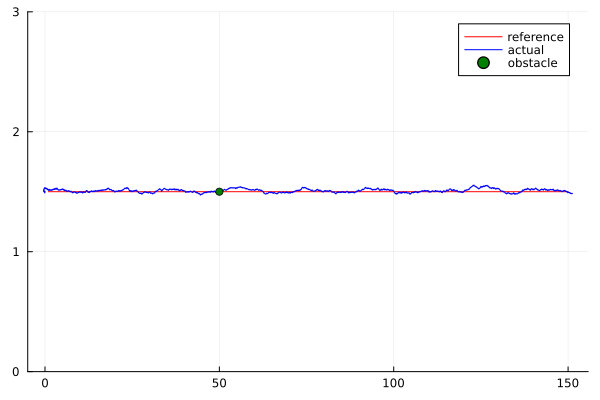

In [60]:
plot(x1,y1,ylims = [0,3],label="reference",color ="red")
plot!(X,Y,ylims = [0,3],label="actual ",color ="blue")
scatter!([x2],[y2],color = "green", label="obstacle")